In [1]:
from Funcs.Utility import *
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable
from datetime import timedelta as td
from scipy import stats
import ray
import warnings
import time
import ray
import dask

In [2]:
print(PATH_INTERMEDIATE)

/var/nfs_share/Overfitting/D-4/Intermediate


In [3]:
esm_path = os.path.join('Intermediate', 'EsmResponse.csv')

In [4]:
esm_df = pd.read_csv(esm_path)

In [5]:
esm_df

,pcode,intendedTriggerTime,actualTriggerTime,reactionTime,responseTime,happy,relaxed,cheerful,content,sad,anxious,depressed,angry,valence,arousal,stress,disturbance
0,P001,1637718007000,1637718007012,1637718323396,1637718364764,4,4,4,5,2,1,1,1,1,1,1,2
1,P001,1637721522000,1637721522014,1637721539351,1637721569541,4,4,4,5,0,0,0,0,1,1,2,1
2,P001,1637726794000,1637726794012,1637727128306,1637727157539,6,5,6,6,0,0,0,0,3,3,0,6
3,P001,1637731738000,1637731738015,1637731765619,1637731788862,4,4,3,4,1,1,1,0,1,1,2,3
4,P001,1637735113000,1637735113010,1637735123563,1637735144845,5,6,4,5,1,0,0,0,2,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,P135,1641356523000,1641356523009,1641356541930,1641356557520,5,6,6,4,0,0,0,0,2,-3,5,6
21834,P135,1641371411000,1641371412098,1641371431813,1641371448498,5,6,5,4,0,5,1,0,1,-3,4,6
21835,P135,1641375915000,1641375915007,1641375924655,1641375941705,5,6,4,0,0,2,0,0,2,-3,4,4
21836,P135,1641379289000,1641379290110,1641379323048,1641379344457,5,6,6,6,0,2,0,0,1,-3,2,5


In [6]:
esm_df = esm_df[['pcode', 'responseTime', 'stress']]

In [7]:
esm_df

,pcode,responseTime,stress
0,P001,1637718364764,1
1,P001,1637721569541,2
2,P001,1637727157539,0
3,P001,1637731788862,2
4,P001,1637735144845,1
...,...,...,...
21833,P135,1641356557520,5
21834,P135,1641371448498,4
21835,P135,1641375941705,4
21836,P135,1641379344457,2


In [8]:
# Convert responseTime and stress to numeric, coerce errors to NaN
esm_df['responseTime'] = pd.to_numeric(esm_df['responseTime'], errors='coerce')
esm_df['stress'] = pd.to_numeric(esm_df['stress'], errors='coerce')

# Drop rows with NaN values
esm_df.dropna(subset=['responseTime', 'stress'], inplace=True)

/tmp/ipykernel_37041/4055246896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esm_df['responseTime'] = pd.to_numeric(esm_df['responseTime'], errors='coerce')
/tmp/ipykernel_37041/4055246896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esm_df['stress'] = pd.to_numeric(esm_df['stress'], errors='coerce')
/tmp/ipykernel_37041/4055246896.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [9]:
print("NaN values per column:")
print(esm_df.isna().sum())

NaN values per column:
pcode           0
responseTime    0
stress          0
dtype: int64


In [10]:
# Check the unique values of responseTime and stress
print("Unique values in responseTime:", esm_df['responseTime'].unique())
print("Unique values in stress:", esm_df['stress'].unique())

Unique values in responseTime: [1637718364764 1637721569541 1637727157539 ... 1641375941705 1641379344457
 1641384298624]
Unique values in stress: [1 2 0 4 3 6 5]


In [11]:
esm_df.head()

,pcode,responseTime,stress
0,P001,1637718364764,1
1,P001,1637721569541,2
2,P001,1637727157539,0
3,P001,1637731788862,2
4,P001,1637735144845,1


In [12]:
print("Basic Statistics:")
print(esm_df.describe())

Basic Statistics:
       responseTime       stress
count  2.183800e+04  21838.00000
mean   1.639389e+12      2.32851
std    8.768959e+08      1.72344
min    1.637717e+12      0.00000
25%    1.638704e+12      1.00000
50%    1.639368e+12      2.00000
75%    1.640001e+12      4.00000
max    1.641905e+12      6.00000


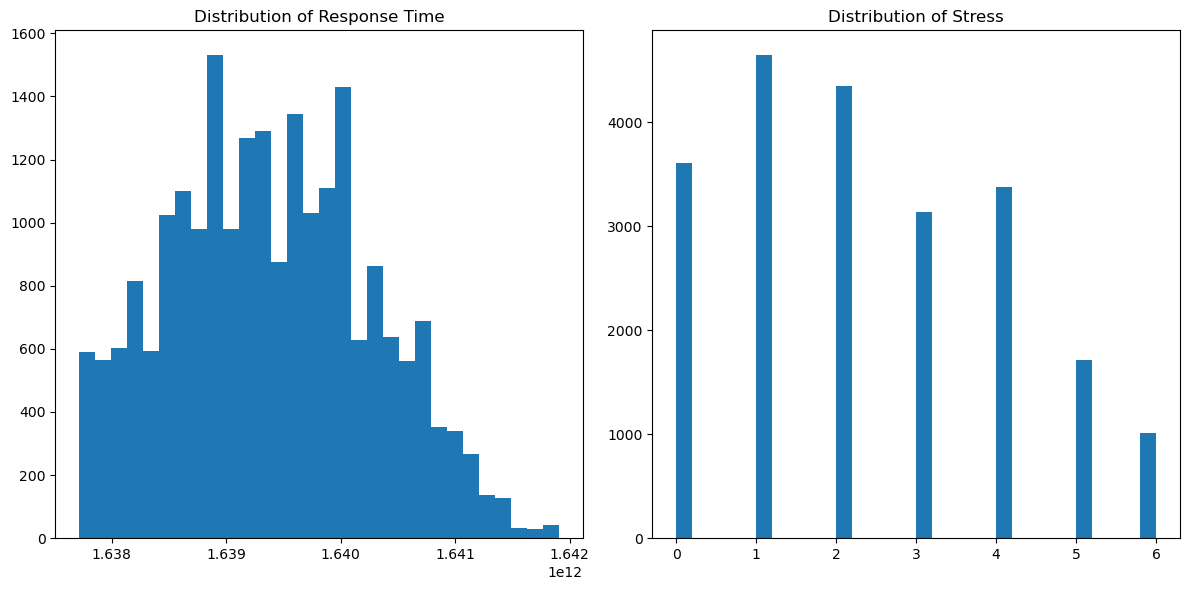

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(esm_df['responseTime'], bins=30)
plt.title('Distribution of Response Time')

plt.subplot(1, 2, 2)
plt.hist(esm_df['stress'], bins=30)
plt.title('Distribution of Stress')

plt.tight_layout()
plt.show()

In [14]:
def calculate_step_count(user_folder, response_time):
    step_file_path = os.path.join(user_folder, 'Fitbit-Calorie.csv')
    if not os.path.exists(step_file_path):
        print(f"File does not exist: {step_file_path}")
        return None

    steps_df = pd.read_csv(step_file_path)
    steps_df['timestamp'] = pd.to_numeric(steps_df['timestamp'], errors='coerce')
    steps_df['value'] = pd.to_numeric(steps_df['value'], errors='coerce')

    start_time = response_time - 30 * 60 * 1000  # 30 minutes before
    end_time = response_time + 30 * 60 * 1000   # 30 minutes after

    # Filter steps within the 1-hour window
    mask = (steps_df['timestamp'] >= start_time) & (steps_df['timestamp'] <= end_time)
    step_count = steps_df.loc[mask, 'value'].sum()

    print(f"User folder: {user_folder}, Response time: {response_time}, Calorie count: {step_count}")

    return step_count

In [15]:
step_counts = []
for index, row in esm_df.iterrows():
    user_folder = os.path.join(PATH_SENSOR, row['pcode'])
    response_time = row['responseTime']
    step_count = calculate_step_count(user_folder, response_time)
    step_counts.append(step_count)

User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637718364764, Calorie count: 68.46665143966675
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637721569541, Calorie count: 125.50405263900757
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637727157539, Calorie count: 191.79370403289795
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637731788862, Calorie count: 103.08095216751099
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637735144845, Calorie count: 99.5977520942688
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637738679285, Calorie count: 85.3384017944336
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637741895183, Calorie count: 99.16235208511353
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637746467521, Calorie count: 83.81450176239014
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637749842040, Calorie count: 102.5367021560669
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1638770689387, Calorie count: 86.97115182876587
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1638774582850, Calorie count: 92.84905195236206
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1638777971411, Calorie count: 77.50120162963867
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1638782487620, Calorie count: 71.1879014968872
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1638846188134, Calorie count: 251.11695528030396
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1638850139152, Calorie count: 171.11220359802246
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1638853049098, Calorie count: 99.81545209884644
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1638856806148, Calorie count: 85.01185178756714
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1638860966292, Calorie count: 101.01280212402344
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639797124456, Calorie count: 143.24660301208496
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639801254936, Calorie count: 362.79705715179443
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639804692482, Calorie count: 112.33320188522339
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639809944434, Calorie count: 107.43495225906372
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639814419083, Calorie count: 380.539608001709
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639817902974, Calorie count: 192.1202540397644
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639822277214, Calorie count: 79.35165166854858
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639879952298, Calorie count: 68.68435144424438
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639883528678, Calorie count: 76.5215516090393
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638250731651, Calorie count: 78.88905882835388
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638255016105, Calorie count: 193.9990999698639
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638263267040, Calorie count: 169.500119805336
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638267505952, Calorie count: 87.446120262146
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638275356310, Calorie count: 71.85585844516754
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638324705072, Calorie count: 117.80609905719757
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638328903765, Calorie count: 101.86418104171753
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638334120893, Calorie count: 100.45753943920135
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638337165381, Calorie count: 111.82787942886353
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639029287929, Calorie count: 82.75731825828552
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639032948195, Calorie count: 85.68781924247742
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639037142418, Calorie count: 86.50835919380188
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639041078442, Calorie count: 209.82379961013794
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639045633191, Calorie count: 119.68161880970001
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639049512924, Calorie count: 83.92951929569244
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639054056348, Calorie count: 85.92225933074951
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639101153435, Calorie count: 98.58201920986176
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639104960110, Calorie count: 174.77502048015594
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639801654012, Calorie count: 145.93889963626862
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639805251013, Calorie count: 96.23761987686157
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639810093058, Calorie count: 117.68887996673584
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639814685120, Calorie count: 144.8839213848114
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639823428745, Calorie count: 132.45860016345978
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639826895096, Calorie count: 139.37458086013794
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639830594627, Calorie count: 93.65878057479858
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639883280736, Calorie count: 79.35793900489807
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639888450599, Calorie count: 117.45444047451019
User folder: /

User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638168216204, Calorie count: 208.3274780511856
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638172553669, Calorie count: 93.75880026817322
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638177209329, Calorie count: 160.07600247859955
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638182176744, Calorie count: 87.81311929225922
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638187183339, Calorie count: 94.21615874767303
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638190447103, Calorie count: 84.26857852935791
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638237949040, Calorie count: 88.38481998443604
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638242479303, Calorie count: 165.564319729805
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638246027352, Calorie count: 227.07924151420593
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639042934953, Calorie count: 192.09120047092438
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639047596158, Calorie count: 105.6501613855362
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639052891980, Calorie count: 121.54342103004456
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639100461943, Calorie count: 74.89269828796387
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639105765400, Calorie count: 233.93963885307312
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639109638300, Calorie count: 253.8348010778427
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639112357793, Calorie count: 317.1791603565216
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639115575081, Calorie count: 228.4513213634491
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639120255170, Calorie count: 106.90790092945099
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639900784435, Calorie count: 243.6585396528244
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639905478416, Calorie count: 330.78562021255493
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639912745040, Calorie count: 114.22566068172455
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639917594721, Calorie count: 125.88834130764008
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639964616387, Calorie count: 71.00513768196106
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639969263756, Calorie count: 79.92365896701813
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639972831301, Calorie count: 150.4714411497116
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639979826045, Calorie count: 222.0482804775238
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639984037421, Calorie count: 454.0441384315491
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638434772343, Calorie count: 129.73656022548676
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638438861002, Calorie count: 154.0687220096588
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638444100766, Calorie count: 75.93311965465546
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638448498563, Calorie count: 75.09407889842987
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638499221057, Calorie count: 161.72496020793915
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638509961582, Calorie count: 97.64327955245972
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638513914924, Calorie count: 95.6505595445633
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638516999295, Calorie count: 92.71391880512238
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638520363141, Calorie count: 82.22591924667358
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639465395879, Calorie count: 88.93823885917664
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639468091437, Calorie count: 120.19247913360596
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639476712121, Calorie count: 97.85304009914398
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639481556966, Calorie count: 157.63463985919952
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639538020017, Calorie count: 115.57776033878326
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639548131795, Calorie count: 69.11591923236847
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639550983171, Calorie count: 73.94039916992188
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639554450116, Calorie count: 128.58287978172302
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639559357154, Calorie count: 100.16040027141571
User folder: /

User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1638436678329, Calorie count: 179.75440895557404
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1638441426152, Calorie count: 176.1982694864273
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1638496635499, Calorie count: 50.802000761032104
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1638500850802, Calorie count: 50.802000761032104
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1638506184494, Calorie count: 153.67604875564575
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1638513890919, Calorie count: 94.49171984195709
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1638518035241, Calorie count: 153.33736991882324
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1638522747031, Calorie count: 70.53011119365692
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1638527548013, Calorie count: 144.53168988227844
User folder: 

User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639729977295, Calorie count: 105.4988204240799
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639733212305, Calorie count: 78.1504100561142
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639796352243, Calorie count: 56.136210441589355
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639800263002, Calorie count: 81.28320056200027
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639809932263, Calorie count: 55.543520867824554
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639815033761, Calorie count: 128.3597211241722
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639820472216, Calorie count: 117.5219612121582
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639824859743, Calorie count: 165.61452043056488
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639829306735, Calorie count: 117.35261917114258
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638065337439, Calorie count: 154.58615899085999
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638070130632, Calorie count: 119.58551895618439
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638078841189, Calorie count: 214.01432979106903
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638083577141, Calorie count: 252.90392684936523
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638087650450, Calorie count: 148.38812935352325
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638091812728, Calorie count: 122.86682951450348
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638095382902, Calorie count: 103.90814888477325
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638099788702, Calorie count: 86.52935910224915
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638151947336, Calorie count: 197.24318945407867
User folder

User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639013704004, Calorie count: 245.00447690486908
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639017317028, Calorie count: 180.10745859146118
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639020349350, Calorie count: 171.35729908943176
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639023603151, Calorie count: 169.6558791399002
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639028221038, Calorie count: 132.95381891727448
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639037407369, Calorie count: 100.6268401145935
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639446623775, Calorie count: 122.6237678527832
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639450333388, Calorie count: 136.11359858512878
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639455025565, Calorie count: 95.15798902511597
User folder: /

User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640349365047, Calorie count: 152.6416792869568
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640401595708, Calorie count: 99.41153919696808
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640405119219, Calorie count: 168.68363916873932
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640408859361, Calorie count: 99.77612805366516
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640414419931, Calorie count: 72.91799783706665
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640430948256, Calorie count: 83.61263823509216
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640435514622, Calorie count: 78.26531827449799
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640483473317, Calorie count: 79.35908889770508
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640487995314, Calorie count: 121.6515280008316
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638328041214, Calorie count: 83.60289001464844
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638332080831, Calorie count: 98.46359944343567
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638345788320, Calorie count: 87.5232001543045
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638353061321, Calorie count: 85.24395072460175
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638358281082, Calorie count: 68.10398960113525
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638362925053, Calorie count: 56.25188982486725
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638409626910, Calorie count: 55.24902033805847
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638414482168, Calorie count: 57.25476002693176
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638418170980, Calorie count: 59.807520508766174
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1639384858203, Calorie count: 109.85984933376312
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1639392417121, Calorie count: 71.4772800207138
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1639453763906, Calorie count: 55.61370015144348
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1639457848665, Calorie count: 55.61370015144348
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1639462606535, Calorie count: 229.74839842319489
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1639468181522, Calorie count: 70.56558048725128
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1639471741499, Calorie count: 99.55763959884644
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1639478996855, Calorie count: 69.28920090198517
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1639483894436, Calorie count: 66.5540999174118
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637914196950, Calorie count: 138.59889841079712
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637917964819, Calorie count: 169.46478813886642
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637921648491, Calorie count: 125.75936830043793
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637930608349, Calorie count: 85.28509050607681
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637979728286, Calorie count: 125.24918895959854
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637983056329, Calorie count: 147.27195799350739
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637987890293, Calorie count: 89.6216179728508
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637992559682, Calorie count: 202.4564287662506
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637997155129, Calorie count: 440.5404282808304
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1638701305149, Calorie count: 184.26000893115997
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1638754522366, Calorie count: 71.5952582359314
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1638763298702, Calorie count: 60.03117972612381
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1638767445508, Calorie count: 88.68628937005997
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1638772888028, Calorie count: 68.19405901432037
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1638777193746, Calorie count: 77.88747906684875
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1638780263548, Calorie count: 82.05394870042801
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1638787718082, Calorie count: 88.68628823757172
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1638792088533, Calorie count: 69.38447916507721
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639655233576, Calorie count: 81.20364904403687
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639705443270, Calorie count: 113.77013850212097
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639709280954, Calorie count: 100.76054900884628
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639712149451, Calorie count: 140.72464925050735
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639716099964, Calorie count: 99.65515929460526
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639721485539, Calorie count: 57.14015954732895
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639724020345, Calorie count: 119.4671488404274
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639729094634, Calorie count: 85.62520909309387
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639733134879, Calorie count: 185.280368745327
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638085427704, Calorie count: 98.66399788856506
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638089570593, Calorie count: 90.03089809417725
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638092762356, Calorie count: 120.3700783252716
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638097720987, Calorie count: 83.49440801143646
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638153320403, Calorie count: 133.44305777549744
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638162011265, Calorie count: 107.54375743865967
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638164711714, Calorie count: 98.91065764427185
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638168253495, Calorie count: 115.68353796005249
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638172531269, Calorie count: 95.45741772651672
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639203346843, Calorie count: 82.26110804080963
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639208582299, Calorie count: 180.3084568977356
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639213123891, Calorie count: 95.70407772064209
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639225693480, Calorie count: 119.26010739803314
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639282436089, Calorie count: 103.10387802124023
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639289869290, Calorie count: 267.1327772140503
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639295531536, Calorie count: 116.91683840751648
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639303824622, Calorie count: 115.9301974773407
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639308688250, Calorie count: 101.25392830371857
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640396906724, Calorie count: 160.94564831256866
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640401898084, Calorie count: 162.5489376783371
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640409885763, Calorie count: 105.20048797130585
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640419205618, Calorie count: 103.96718776226044
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640422497549, Calorie count: 105.94046771526337
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640426036560, Calorie count: 73.99799823760986
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640483291246, Calorie count: 166.37216746807098
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640500871234, Calorie count: 219.5273984670639
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640512776760, Calorie count: 139.23956716060638
User folder: 

User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638236894173, Calorie count: 71.6100025177002
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638252523796, Calorie count: 185.82794892787933
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638257866702, Calorie count: 106.6989004611969
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638261965274, Calorie count: 156.46785020828247
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638271029460, Calorie count: 255.88639771938324
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638274910800, Calorie count: 108.36979830265045
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638326831253, Calorie count: 109.32460069656372
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638331376342, Calorie count: 174.7283993959427
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638334851683, Calorie count: 79.367751121521
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639221720745, Calorie count: 181.41199862957
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639226958007, Calorie count: 165.89649879932404
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639283499518, Calorie count: 312.57764744758606
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639288438155, Calorie count: 95.83805119991302
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639291188134, Calorie count: 85.21590089797974
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639296084031, Calorie count: 114.2179514169693
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639300742126, Calorie count: 259.7056003808975
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639303971884, Calorie count: 298.3749989271164
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639313214577, Calorie count: 121.73699975013733
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1637929310795, Calorie count: 429.89562118053436
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1637977605200, Calorie count: 93.72131812572479
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1637981472639, Calorie count: 109.22834968566895
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1637991389795, Calorie count: 190.83833849430084
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1637996381025, Calorie count: 117.7175977230072
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1637999490182, Calorie count: 197.17697894573212
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1638007002820, Calorie count: 113.18999874591827
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1638011553168, Calorie count: 80.591277718544
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1638068622978, Calorie count: 103.3424676656723
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1638956740131, Calorie count: 186.87668991088867
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1638959756605, Calorie count: 167.1816302537918
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1638967221975, Calorie count: 382.12943863868713
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639014225253, Calorie count: 80.70446801185608
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639021911148, Calorie count: 77.53514790534973
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639031591751, Calorie count: 106.9645482301712
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639035033466, Calorie count: 144.31724870204926
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639044294915, Calorie count: 111.152578830719
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639047038211, Calorie count: 97.00382804870605
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639918886995, Calorie count: 84.32654738426208
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639965757346, Calorie count: 141.71387898921967
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639970189713, Calorie count: 123.94304895401001
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639974590477, Calorie count: 167.18162941932678
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639977751997, Calorie count: 93.3817480802536
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639982690231, Calorie count: 72.78116750717163
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639986591059, Calorie count: 146.46785855293274
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639990537303, Calorie count: 169.33224046230316
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639995469439, Calorie count: 276.5231696367264
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638351656876, Calorie count: 133.45410120487213
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638355141759, Calorie count: 131.72514188289642
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638360447178, Calorie count: 89.1495019197464
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638410486754, Calorie count: 82.66590178012848
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638415688529, Calorie count: 65.48436141014099
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638420469862, Calorie count: 136.91202127933502
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638428420668, Calorie count: 208.77192151546478
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638433375428, Calorie count: 140.8021823167801
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638438185525, Calorie count: 209.85252118110657
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639304351398, Calorie count: 110.76150166988373
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639309837260, Calorie count: 309.26772356033325
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639313393006, Calorie count: 136.04753983020782
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639365479302, Calorie count: 120.8110818862915
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639370423914, Calorie count: 77.58708167076111
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639374350559, Calorie count: 90.33816194534302
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639380145310, Calorie count: 73.04856157302856
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639384530431, Calorie count: 89.79786145687103
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639387697050, Calorie count: 81.15306150913239
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1637903097794, Calorie count: 85.81963884830475
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1637906643716, Calorie count: 91.90779888629913
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1637910056139, Calorie count: 83.36095881462097
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1637913986099, Calorie count: 90.26867830753326
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1637918108109, Calorie count: 111.81139969825745
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1637925821924, Calorie count: 79.96563875675201
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1637929058956, Calorie count: 96.00559771060944
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1637977360962, Calorie count: 152.55523991584778
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1637986438408, Calorie count: 71.18463826179504
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638861037308, Calorie count: 183.58144068717957
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638864925708, Calorie count: 205.12416076660156
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638868885683, Calorie count: 109.23564159870148
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638878018245, Calorie count: 102.79624128341675
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638881533479, Calorie count: 129.95880091190338
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638928268706, Calorie count: 86.40504038333893
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638932509493, Calorie count: 313.3060792684555
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638936107142, Calorie count: 275.25507974624634
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638939890038, Calorie count: 319.3942391872406
User folder: 

User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639973911069, Calorie count: 114.15300011634827
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639978718857, Calorie count: 78.32652008533478
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639985061419, Calorie count: 76.1019995212555
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639988820730, Calorie count: 117.1970808506012
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639992333109, Calorie count: 238.84319937229156
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1640002401088, Calorie count: 89.80036056041718
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1640051296035, Calorie count: 83.24387955665588
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1640060431007, Calorie count: 284.50439846515656
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1640065157641, Calorie count: 338.24411702156067
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638432391936, Calorie count: 55.47099959850311
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638435345941, Calorie count: 55.129640102386475
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638443804341, Calorie count: 59.56731986999512
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638446880519, Calorie count: 57.60449981689453
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638496624030, Calorie count: 52.48409974575043
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638503278138, Calorie count: 54.4469199180603
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638507165539, Calorie count: 51.630699634552
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638510927567, Calorie count: 65.455779671669
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638521659874, Calorie count: 66.30917966365814
User folder: /var/nfs_s

User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639485985399, Calorie count: 62.89558005332947
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639544258993, Calorie count: 51.71603965759277
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639549052322, Calorie count: 53.25215983390808
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639552705666, Calorie count: 72.62433969974518
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639556959105, Calorie count: 150.9664580821991
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639564745952, Calorie count: 52.398759841918945
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639567881393, Calorie count: 51.886719703674316
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639622702220, Calorie count: 52.99613976478577
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639630770755, Calorie count: 58.884599924087524
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638068057789, Calorie count: 297.20548593997955
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638072352823, Calorie count: 210.69724142551422
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638075534730, Calorie count: 190.82700157165527
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638078732925, Calorie count: 139.2128404378891
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638082889884, Calorie count: 140.1821197271347
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638086660572, Calorie count: 157.7503205537796
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638090109905, Calorie count: 184.1632000207901
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638093999351, Calorie count: 207.42592024803162
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638099404411, Calorie count: 142.6053216457367
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638874126953, Calorie count: 111.70951914787292
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638877483279, Calorie count: 137.88008058071136
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638881847123, Calorie count: 109.40748023986816
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638929925913, Calorie count: 155.08479964733124
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638934734502, Calorie count: 115.58664095401764
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638952179026, Calorie count: 117.64635992050171
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638955660097, Calorie count: 274.0639247894287
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638959956354, Calorie count: 438.7203680276871
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1638963716336, Calorie count: 77.66355729103088
User folder: 

User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639823475675, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639828265003, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639880512988, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639892728179, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639896633287, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639901936860, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639915223825, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639967377557, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639974840691, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639983729798, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P020, Resp

User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638355130654, Calorie count: 87.27720105648041
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638359854818, Calorie count: 126.78399980068207
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638416310615, Calorie count: 82.86239910125732
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638419941964, Calorie count: 125.19920074939728
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638423847170, Calorie count: 72.44799900054932
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638432517626, Calorie count: 159.95160102844238
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638441489229, Calorie count: 121.57680082321167
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638446388604, Calorie count: 72.44799959659576
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638499389602, Calorie count: 70.52359879016876
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1639360895870, Calorie count: 107.31360006332397
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1639365325597, Calorie count: 100.74800074100494
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1639369627465, Calorie count: 155.5368002653122
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1639377764332, Calorie count: 115.23760056495667
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1639387185276, Calorie count: 72.3347989320755
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1639390508856, Calorie count: 90.67320120334625
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1639395067358, Calorie count: 109.80400097370148
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1639398141074, Calorie count: 92.93719983100891
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1639452074580, Calorie count: 83.42839872837067
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1637752736998, Calorie count: 131.80392110347748
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1637809356852, Calorie count: 84.86828088760376
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1637814341815, Calorie count: 85.58852124214172
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1637819147629, Calorie count: 108.03600239753723
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1637823903291, Calorie count: 194.22472071647644
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1637827349865, Calorie count: 94.59152114391327
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1637830878703, Calorie count: 91.11036109924316
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1637843944720, Calorie count: 124.9616425037384
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1637895810107, Calorie count: 172.8576010465622
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638795093818, Calorie count: 134.80492174625397
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638844737315, Calorie count: 125.08168041706085
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638848552395, Calorie count: 72.02399969100952
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638858094969, Calorie count: 72.02399969100952
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638861157516, Calorie count: 72.02399969100952
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638866462202, Calorie count: 161.33376109600067
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638869837871, Calorie count: 266.48880112171173
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638873958870, Calorie count: 205.26840031147003
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638935167644, Calorie count: 87.50916111469269
User folder: /

User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637719360679, Calorie count: 187.2483196258545
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637723924406, Calorie count: 262.4353197813034
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637732297366, Calorie count: 143.57448041439056
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637749206098, Calorie count: 186.07148039340973
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637754117759, Calorie count: 122.78363978862762
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637757737940, Calorie count: 196.27075958251953
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637805663632, Calorie count: 136.90572094917297
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637809995943, Calorie count: 183.3255194425583
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637813932736, Calorie count: 168.94192004203796
User folder: 

User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1638773230722, Calorie count: 118.86083960533142
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1638778006172, Calorie count: 234.19115912914276
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1638782653181, Calorie count: 289.76415967941284
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1638788012540, Calorie count: 126.83720016479492
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1638792089973, Calorie count: 170.90332007408142
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1638795240537, Calorie count: 228.17619848251343
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1638842802954, Calorie count: 150.50476038455963
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1638846806606, Calorie count: 140.95927941799164
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1638864388034, Calorie count: 432.0310387611389
User folder

User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639807713960, Calorie count: 117.89968073368073
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639812037077, Calorie count: 110.72657978534698
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639824749149, Calorie count: 110.59616148471832
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639829950220, Calorie count: 335.17939817905426
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639881151960, Calorie count: 95.72828125953674
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639884591774, Calorie count: 103.03179955482483
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639889584897, Calorie count: 303.6177611351013
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639894207411, Calorie count: 142.15780007839203
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639903295053, Calorie count: 595.7585604190826
User folder: 

User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1637826647124, Calorie count: 88.80612123012543
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1637831955304, Calorie count: 130.6180204153061
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1637835996766, Calorie count: 96.10847926139832
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1637841288436, Calorie count: 91.75062227249146
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1637844125509, Calorie count: 79.97262191772461
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1637890958099, Calorie count: 209.05950260162354
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1637894276078, Calorie count: 88.80611944198608
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1637899812981, Calorie count: 215.8907390832901
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1637903172351, Calorie count: 191.74584126472473
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1638707653473, Calorie count: 96.93293845653534
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1638755237336, Calorie count: 106.59090042114258
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1638763418487, Calorie count: 118.01555979251862
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1638767953020, Calorie count: 116.83775961399078
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1638772632450, Calorie count: 95.04845976829529
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1638781095714, Calorie count: 108.82871985435486
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1638785819845, Calorie count: 115.77774107456207
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1638788982403, Calorie count: 124.0223400592804
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1638793890338, Calorie count: 97.52183961868286
User folder: /

User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639704963527, Calorie count: 85.9794020652771
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639710335071, Calorie count: 77.49924218654633
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639715017120, Calorie count: 75.26142275333405
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639718109962, Calorie count: 78.55926215648651
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639723524698, Calorie count: 79.03038239479065
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639728189553, Calorie count: 163.36085987091064
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639732051577, Calorie count: 120.60672175884247
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639734724039, Calorie count: 187.15242063999176
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639739021966, Calorie count: 99.75965881347656
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638170169943, Calorie count: 106.87515211105347
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638178451869, Calorie count: 180.18715238571167
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638182779482, Calorie count: 347.88835287094116
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638236171250, Calorie count: 79.51157975196838
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638239327059, Calorie count: 178.95833909511566
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638242537497, Calorie count: 213.90219056606293
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638251627512, Calorie count: 68.74199867248537
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638256535278, Calorie count: 76.4181901216507
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638259690347, Calorie count: 233.49365949630737
User folder: /

User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1639131418588, Calorie count: 149.07100105285645
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1639135270323, Calorie count: 278.64809799194336
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1639139459737, Calorie count: 124.41694951057434
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1639187472212, Calorie count: 68.80200147628784
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1639199484505, Calorie count: 68.80200147628784
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1639204250691, Calorie count: 68.80200147628784
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1639209391921, Calorie count: 68.80200147628784
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1639213535170, Calorie count: 104.57904076576233
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1639217511063, Calorie count: 241.03633892536163
User folder: /

User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637737047683, Calorie count: 62.76120960712433
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637747252942, Calorie count: 68.589639544487
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637752236807, Calorie count: 61.24074959754944
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637755849920, Calorie count: 54.06079947948456
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637805403645, Calorie count: 53.04715931415558
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637810728549, Calorie count: 144.69711029529572
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637816103871, Calorie count: 203.82611119747162
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637819475604, Calorie count: 160.66193985939026
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637833614161, Calorie count: 84.63893949985504
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1638768181738, Calorie count: 52.16060048341751
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1638771411289, Calorie count: 55.525800704956055
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1638776292319, Calorie count: 50.47800064086914
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1638781432675, Calorie count: 98.34797018766403
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1638786822799, Calorie count: 58.47035038471222
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1638793239785, Calorie count: 102.04968929290771
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1638846105867, Calorie count: 66.63096058368683
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1638854935933, Calorie count: 59.648170590400696
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1638858197793, Calorie count: 54.34798038005829
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639791327669, Calorie count: 87.49520015716553
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639795917919, Calorie count: 106.84509998559952
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639799890896, Calorie count: 193.7513906955719
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639814012831, Calorie count: 98.85274976491928
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639819150076, Calorie count: 55.27341026067734
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639832071196, Calorie count: 50.7303906083107
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639878348047, Calorie count: 50.64626061916351
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639882274427, Calorie count: 51.23517054319382
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639893014935, Calorie count: 57.12427067756653
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638516851780, Calorie count: 92.3857204914093
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638520798650, Calorie count: 58.56144106388092
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638525175328, Calorie count: 78.8391809463501
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638534505694, Calorie count: 57.80418074131012
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638591883729, Calorie count: 82.70961940288544
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638595296811, Calorie count: 78.25020027160645
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638600253583, Calorie count: 70.42518103122711
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638603450237, Calorie count: 66.47060024738312
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638607203561, Calorie count: 57.29934072494507
User folder: /var/nfs

User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639536947760, Calorie count: 71.51900088787079
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639556027300, Calorie count: 86.41178023815155
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639560582761, Calorie count: 105.84811997413635
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639563866826, Calorie count: 69.75206053256989
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639619975808, Calorie count: 92.38572013378143
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639650271107, Calorie count: 80.10128057003021
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639653609241, Calorie count: 73.70664072036743
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639706591479, Calorie count: 50.48400163650513
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639717756650, Calorie count: 50.48400163650513
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1637910948330, Calorie count: 87.89752149581909
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1637915286590, Calorie count: 91.86196994781494
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1637920245121, Calorie count: 83.36672031879425
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1637924941355, Calorie count: 78.15629923343658
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1637984290977, Calorie count: 85.12639963626862
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1637989204891, Calorie count: 74.71199882030487
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1637993340987, Calorie count: 72.10839855670929
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1637997776997, Calorie count: 76.18359982967377
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638001446208, Calorie count: 219.49480068683624
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638841601183, Calorie count: 77.91480040550232
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638845127043, Calorie count: 178.18776094913483
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638850047911, Calorie count: 323.7416400909424
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638854885055, Calorie count: 88.30343902111053
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638858468739, Calorie count: 81.64115917682648
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638863005849, Calorie count: 73.51091957092285
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638872250448, Calorie count: 68.3165990114212
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638877529659, Calorie count: 68.09075903892517
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638880967382, Calorie count: 76.67267990112305
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639738973290, Calorie count: 116.42051935195923
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639743798543, Calorie count: 157.63631916046143
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639791396617, Calorie count: 79.15692007541656
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639795889174, Calorie count: 203.8206012248993
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639799587760, Calorie count: 156.84587907791138
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639813569058, Calorie count: 319.56360125541687
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639817317971, Calorie count: 108.40319979190826
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639825503940, Calorie count: 74.86595892906189
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639882205991, Calorie count: 70.34915912151337
User folder: /

User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639051137017, Calorie count: 95.32040071487427
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639106689736, Calorie count: 225.26080095767975
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639113635455, Calorie count: 287.115198135376
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639119289801, Calorie count: 192.6025996208191
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639120945826, Calorie count: 187.29420018196106
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639124462985, Calorie count: 87.81940007209778
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639127602347, Calorie count: 87.47320079803467
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639132261961, Calorie count: 118.74660050868988
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639137868984, Calorie count: 92.43539917469025
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640344831543, Calorie count: 73.1636016368866
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640344831543, Calorie count: 73.1636016368866
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640349114809, Calorie count: 82.62639904022217
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640402549408, Calorie count: 165.13740015029907
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640406858010, Calorie count: 145.5193977355957
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640411563482, Calorie count: 108.36059892177582
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640415635863, Calorie count: 166.75299954414368
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640423111994, Calorie count: 87.01159918308258
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640427106170, Calorie count: 144.01919972896576
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1637926942571, Calorie count: 75.93838155269623
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1637983659946, Calorie count: 239.43226194381714
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1637986811638, Calorie count: 104.63950109481812
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1637991352887, Calorie count: 54.070860505104065
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1637996354854, Calorie count: 52.53330051898956
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638000779687, Calorie count: 53.302080512046814
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638014111959, Calorie count: 62.356600761413574
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638016915332, Calorie count: 55.779260754585266
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638069615653, Calorie count: 51.42284035682678
User folder: 

User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638877187546, Calorie count: 52.10620045661926
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638881366419, Calorie count: 52.10620045661926
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638927767241, Calorie count: 60.47736048698425
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638931821803, Calorie count: 52.27704048156738
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638934693659, Calorie count: 60.13568043708801
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638937748271, Calorie count: 59.53774130344391
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638941379848, Calorie count: 64.66294121742249
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638945644207, Calorie count: 55.010480642318726
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638949574739, Calorie count: 54.070860624313354
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639817782947, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639826491822, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639831709924, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639878815594, Calorie count: 151.62050020694733
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639882594035, Calorie count: 96.7808598279953
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639886853131, Calorie count: 112.07104122638702
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639890598608, Calorie count: 61.75866115093231
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639894095358, Calorie count: 60.56278109550476
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639897838447, Calorie count: 60.22110092639923
User folder: /var/nfs_share/D#4/newdata/P030, Response time:

User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638596149294, Calorie count: 126.21887969970703
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638610915928, Calorie count: 134.80362045764923
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638619954566, Calorie count: 107.19323897361755
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638669193901, Calorie count: 70.30205941200256
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638674815474, Calorie count: 147.10067856311798
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638678832032, Calorie count: 153.13319945335388
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638682582006, Calorie count: 107.77328956127167
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638691847640, Calorie count: 87.93557941913605
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638701178026, Calorie count: 77.14664924144745
User folder: 

User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1639820802867, Calorie count: 118.0981798171997
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1639824152456, Calorie count: 80.2789192199707
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1639877985615, Calorie count: 97.10036885738373
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1639882828926, Calorie count: 107.54126942157745
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1639886692110, Calorie count: 89.09567856788635
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1639890958183, Calorie count: 135.26765930652618
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1639898678678, Calorie count: 119.83832907676697
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1639903329916, Calorie count: 107.77328932285309
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1639964422927, Calorie count: 145.70855975151062
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1637979150739, Calorie count: 116.48339903354645
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1637982435474, Calorie count: 182.13768112659454
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1637991170693, Calorie count: 74.59643912315369
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1637996156479, Calorie count: 74.00814008712769
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1637999961404, Calorie count: 73.53749990463257
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638003874666, Calorie count: 160.0175999403
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638007591371, Calorie count: 80.5970995426178
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638012573553, Calorie count: 90.12755942344666
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638069238719, Calorie count: 171.07763981819153
User folder: /var/nf

User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638850428117, Calorie count: 122.01341891288757
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638854611454, Calorie count: 167.66549968719482
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638871305736, Calorie count: 180.96108031272888
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638874710455, Calorie count: 109.89443922042847
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638926649458, Calorie count: 148.4869201183319
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638931840500, Calorie count: 159.54696035385132
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638936069378, Calorie count: 198.02177834510803
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638940861606, Calorie count: 98.01077902317047
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638957757538, Calorie count: 95.53991913795471
User folder: 

User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639818867788, Calorie count: 95.53991937637329
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639822830751, Calorie count: 148.8399008512497
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639825749216, Calorie count: 95.77523970603943
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639884466825, Calorie count: 167.43017876148224
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639889457781, Calorie count: 185.43216013908386
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639892511590, Calorie count: 93.8926784992218
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639896781508, Calorie count: 138.13283908367157
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639902040082, Calorie count: 74.00813901424408
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639905225011, Calorie count: 81.65603923797607
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638344169549, Calorie count: 62.45964968204498
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638347267591, Calorie count: 183.96388709545135
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638352066013, Calorie count: 98.04817116260529
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638358513273, Calorie count: 170.03403913974762
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638363250334, Calorie count: 74.68196964263916
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638410088724, Calorie count: 203.7352900505066
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638417449602, Calorie count: 88.79155993461609
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638422763842, Calorie count: 124.73956036567688
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638427567149, Calorie count: 144.96030843257904
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1639293999410, Calorie count: 62.81912922859192
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1639299334646, Calorie count: 70.09859919548035
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1639302891020, Calorie count: 153.49796068668365
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1639306745066, Calorie count: 63.80769968032837
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1639311463320, Calorie count: 80.61338937282562
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1639361260031, Calorie count: 60.39263939857483
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1639365151773, Calorie count: 74.77183961868286
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1639373203448, Calorie count: 60.931859254837036
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1639376417178, Calorie count: 108.38322043418884
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1637930309810, Calorie count: 69.08417880535126
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1637977826930, Calorie count: 64.98827958106995
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1637986982141, Calorie count: 70.72253918647766
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1637995148306, Calorie count: 144.99486017227173
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638004759363, Calorie count: 79.46045899391174
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638016805452, Calorie count: 74.63639891147614
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638064225846, Calorie count: 76.27475965023041
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638069535919, Calorie count: 97.30037939548492
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638073401092, Calorie count: 89.92775928974152
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1639187807670, Calorie count: 64.53317940235138
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1639192183572, Calorie count: 91.56611859798431
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1639195522868, Calorie count: 67.17275929450989
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1639200267799, Calorie count: 117.77988028526306
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1639212790666, Calorie count: 114.95826029777527
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1639216182868, Calorie count: 115.41336059570312
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1639219306094, Calorie count: 70.35845935344696
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1639227304981, Calorie count: 97.48241901397705
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1639282460757, Calorie count: 59.891159653663635
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637815913241, Calorie count: 155.5290002822876
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637829498352, Calorie count: 215.76113998889923
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637834182326, Calorie count: 335.8012491464615
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637842077862, Calorie count: 149.44922935962677
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637845312889, Calorie count: 296.4948310852051
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637890479141, Calorie count: 207.7019098997116
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637893972943, Calorie count: 171.36468029022217
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637897561349, Calorie count: 94.44852077960968
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637902123033, Calorie count: 341.0326838493347
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638675765225, Calorie count: 86.2479008436203
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638679644243, Calorie count: 85.9651209115982
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638683964620, Calorie count: 122.0195701122284
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638686939795, Calorie count: 189.17982029914856
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638691969044, Calorie count: 153.973708152771
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638695225459, Calorie count: 86.67207109928131
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638699956059, Calorie count: 315.299697637558
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638703283381, Calorie count: 225.51705014705658
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638708518382, Calorie count: 132.7652097940445
User folder: /var/nfs

User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639478339639, Calorie count: 228.62763142585754
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639483578682, Calorie count: 169.95078074932098
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639534570639, Calorie count: 86.95485091209412
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639537683469, Calorie count: 112.12227058410645
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639543205448, Calorie count: 185.6450721025467
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639548600205, Calorie count: 262.13706135749817
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639556532071, Calorie count: 119.61593973636627
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639564686944, Calorie count: 200.49102020263672
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639570424667, Calorie count: 154.96343910694122
User folder:

User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1638082469530, Calorie count: 171.7093495130539
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1638092565123, Calorie count: 154.36016929149628
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1638100680769, Calorie count: 105.52103984355927
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1638150589735, Calorie count: 145.38723158836365
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1638155449896, Calorie count: 72.63437247276306
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1638164943313, Calorie count: 124.76996946334839
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1638168860284, Calorie count: 86.97166180610657
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1638187034184, Calorie count: 373.8359489440918
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1638237007528, Calorie count: 104.9821424484253
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639135805134, Calorie count: 259.8485679626465
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639140292315, Calorie count: 331.2980389595032
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639186805791, Calorie count: 71.2124927043915
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639191584224, Calorie count: 192.42776131629944
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639196902127, Calorie count: 345.5168421268463
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639205004123, Calorie count: 80.45471119880676
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639212576684, Calorie count: 155.81434845924377
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639217117769, Calorie count: 404.6433517932892
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639226684692, Calorie count: 124.7699716091156
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1640311548171, Calorie count: 196.3379294872284
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1640315136395, Calorie count: 177.49801993370056
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1640328857882, Calorie count: 245.51127862930298
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1640339641570, Calorie count: 157.47320890426636
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1640401407149, Calorie count: 116.23868989944458
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1640404627082, Calorie count: 216.00727033615112
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1640409902799, Calorie count: 189.70248675346375
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1640418621005, Calorie count: 168.49277925491333
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1640422784484, Calorie count: 79.15132236480713
User folder:

User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1638343492678, Calorie count: 123.59049987792969
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1638354187887, Calorie count: 249.0079904794693
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1638408910650, Calorie count: 122.945680975914
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1638413302452, Calorie count: 236.11159145832062
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1638417211462, Calorie count: 111.76880025863647
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1638421912175, Calorie count: 111.33891928195953
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1638438554200, Calorie count: 371.2013792991638
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1638443310415, Calorie count: 137.88400959968567
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1638446660824, Calorie count: 203.6556499004364
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639455000006, Calorie count: 162.92452132701874
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639460235659, Calorie count: 180.97947883605957
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639472411393, Calorie count: 79.09791779518127
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639475722530, Calorie count: 123.2680881023407
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639478955390, Calorie count: 283.93574047088623
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639538018804, Calorie count: 75.76635038852692
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639541278034, Calorie count: 68.88827097415924
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639547034682, Calorie count: 75.87382078170776
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639550599196, Calorie count: 72.86466097831726
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638190032290, Calorie count: 101.56167888641357
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638240964337, Calorie count: 110.89935779571533
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638245915198, Calorie count: 222.4903987646103
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638262305405, Calorie count: 88.99615848064423
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638272633955, Calorie count: 216.0347204208374
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638325253975, Calorie count: 241.6268812417984
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638330189130, Calorie count: 195.16903817653656
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638334189168, Calorie count: 117.1244797706604
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638337715589, Calorie count: 80.23487877845764
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639273546615, Calorie count: 83.92383801937103
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639276715345, Calorie count: 100.75471913814545
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639281061813, Calorie count: 179.37567842006683
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639286124324, Calorie count: 87.49751794338226
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639290590378, Calorie count: 112.97439932823181
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639297940048, Calorie count: 99.94775974750519
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639301344059, Calorie count: 103.06031882762909
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639305918641, Calorie count: 96.02823901176453
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639313062213, Calorie count: 115.97167778015137
User folder: /

User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638082814401, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638087999340, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638150491628, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638154635108, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638178570265, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638183102109, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638187678586, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638236975148, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638261335448, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638327676455, Calorie count: 196.09620118141174
User folder: /var/nfs_share/D#4/new

User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639387421089, Calorie count: 111.84288156032562
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639391551402, Calorie count: 169.9912827014923
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639399550512, Calorie count: 98.2336813211441
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639449477223, Calorie count: 79.05708003044128
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639454631896, Calorie count: 238.03728079795837
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639459720694, Calorie count: 156.01092159748077
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639466308308, Calorie count: 127.67904138565063
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639473829191, Calorie count: 237.0475207567215
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639482208069, Calorie count: 93.656041264534
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1640582446757, Calorie count: 92.1714015007019
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1640589409331, Calorie count: 86.72772085666656
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1640593319599, Calorie count: 117.53400194644928
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1640599018416, Calorie count: 191.76600074768066
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1640602530984, Calorie count: 129.7822812795639
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1640655952878, Calorie count: 120.75072205066681
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1640661581046, Calorie count: 190.5287994146347
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1640665012794, Calorie count: 90.43932104110718
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1640668865680, Calorie count: 99.96576118469238
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1638855350402, Calorie count: 75.30457931756973
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1638858403265, Calorie count: 72.78196930885315
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1638868342021, Calorie count: 92.86941927671432
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1638873837466, Calorie count: 101.46498018503189
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1638928872584, Calorie count: 66.14843994379044
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1638937578192, Calorie count: 100.81096988916397
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1638950359437, Calorie count: 66.98930966854095
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1638960494534, Calorie count: 152.19746911525726
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1638964666137, Calorie count: 143.13476008176804
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639904157419, Calorie count: 110.62112075090408
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639907601724, Calorie count: 124.82247990369797
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639912380721, Calorie count: 75.77172940969467
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639970074941, Calorie count: 130.80200046300888
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639973113939, Calorie count: 73.90312957763672
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639976378261, Calorie count: 67.08273983001709
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639980672836, Calorie count: 100.53068047761917
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639985754457, Calorie count: 167.42656296491623
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639990559790, Calorie count: 66.24186992645264
User folder: /

User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638598150504, Calorie count: 119.31260085105896
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638605310331, Calorie count: 80.16448080539703
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638616372929, Calorie count: 52.65040045976639
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638620598679, Calorie count: 59.444000244140625
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638669965314, Calorie count: 53.669440388679504
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638674657784, Calorie count: 82.5422403216362
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638678717137, Calorie count: 144.87352126836777
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638684259738, Calorie count: 136.55136090517044
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638687709278, Calorie count: 59.27416056394577
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639555360518, Calorie count: 142.66560018062592
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639559856881, Calorie count: 183.17243993282318
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639564337897, Calorie count: 232.00144052505493
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639567531516, Calorie count: 152.17664223909378
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639570842969, Calorie count: 85.25967985391617
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639620176736, Calorie count: 59.5289204120636
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639627792210, Calorie count: 63.520160377025604
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639633139405, Calorie count: 51.97104048728943
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639636999301, Calorie count: 166.27336090803146
User folder: /

User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638078484414, Calorie count: 82.19308960437775
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638083267018, Calorie count: 171.40396106243134
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638086385866, Calorie count: 158.5380300283432
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638151757550, Calorie count: 72.30440092086792
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638157314701, Calorie count: 175.76349079608917
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638160138983, Calorie count: 131.5302107334137
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638164799597, Calorie count: 159.7076599597931
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638173044123, Calorie count: 227.54620027542114
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638181422872, Calorie count: 117.6009806394577
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1639453206089, Calorie count: 130.7858999967575
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1639474753770, Calorie count: 91.33747088909149
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1639536200183, Calorie count: 63.90433084964752
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1639545905715, Calorie count: 132.27452111244202
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1639549005287, Calorie count: 244.0273494720459
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1639557726927, Calorie count: 186.18382954597473
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1639618066908, Calorie count: 90.06150996685028
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1639625795870, Calorie count: 93.03875029087067
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1639629252815, Calorie count: 94.95269060134888
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637732653787, Calorie count: 100.78457868099213
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637736622505, Calorie count: 142.91081845760345
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637740399572, Calorie count: 81.92573761940002
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637744595726, Calorie count: 90.25301742553711
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637747792487, Calorie count: 81.80327785015106
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637750927091, Calorie count: 93.31451785564423
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637755258309, Calorie count: 77.63963770866394
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637804515848, Calorie count: 86.70167779922485
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637808503108, Calorie count: 90.86531782150269
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1638448842073, Calorie count: 97.23323833942413
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1638494392964, Calorie count: 174.87287938594818
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1638503738769, Calorie count: 250.92054092884064
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1638507164414, Calorie count: 283.9847403764725
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1638510488141, Calorie count: 176.09747874736786
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1638516654666, Calorie count: 75.4353575706482
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1638534688080, Calorie count: 184.7921394109726
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1638580527229, Calorie count: 74.33321750164033
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1638585308538, Calorie count: 76.65995752811432
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639208826750, Calorie count: 165.810840010643
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639213835782, Calorie count: 144.50279831886292
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639218147575, Calorie count: 107.51987743377686
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639221959954, Calorie count: 230.7146406173706
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639273334625, Calorie count: 73.9658374786377
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639278339597, Calorie count: 95.88617813587189
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639283577453, Calorie count: 92.57975828647614
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639290852603, Calorie count: 109.35677802562714
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639295240145, Calorie count: 83.76263785362244
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1640055837690, Calorie count: 89.1508777141571
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1640058965644, Calorie count: 101.7642582654953
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1640063897702, Calorie count: 201.44669997692108
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1640069006555, Calorie count: 170.58677995204926
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1640074282139, Calorie count: 82.41557776927948
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1640079373404, Calorie count: 111.43859827518463
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1640082840657, Calorie count: 233.65367794036865
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1640087657306, Calorie count: 105.68297791481018
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1640091052990, Calorie count: 229.85741877555847
User folder: /

User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638793068981, Calorie count: 100.27538919448853
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638842485176, Calorie count: 86.69273972511292
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638846432577, Calorie count: 82.91321921348572
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638850840673, Calorie count: 129.8028894662857
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638854458941, Calorie count: 166.53509902954102
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638858604339, Calorie count: 112.08638823032379
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638863153109, Calorie count: 103.70057904720306
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638865730779, Calorie count: 113.38559854030609
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638879427194, Calorie count: 285.1175420284271
User folder: /

User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639830969755, Calorie count: 123.89738845825195
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639880357196, Calorie count: 92.12579894065857
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639894043946, Calorie count: 98.26751935482025
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639902469475, Calorie count: 87.04706990718842
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639906539017, Calorie count: 70.86600065231323
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639912003863, Calorie count: 70.86600065231323
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639917220507, Calorie count: 70.86600065231323
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639966852779, Calorie count: 394.2511763572693
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639971939090, Calorie count: 144.68474996089935
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638850692187, Calorie count: 153.5633021593094
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638858574579, Calorie count: 92.72900176048279
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638862964687, Calorie count: 101.5943011045456
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638932994967, Calorie count: 79.58390212059021
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638937174603, Calorie count: 85.69790232181549
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638940980026, Calorie count: 233.6567019224167
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638944965079, Calorie count: 61.140003204345696
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638949396907, Calorie count: 93.03470146656036
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1639016855509, Calorie count: 82.4371029138565
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1640258688141, Calorie count: 61.140003204345696
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1640310021275, Calorie count: 61.140003204345696
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1640318370069, Calorie count: 139.7049013376236
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1640323404327, Calorie count: 67.15210294723511
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1640327545367, Calorie count: 112.39570081233978
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1640331892422, Calorie count: 145.00370109081268
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1640336592244, Calorie count: 96.2955013513565
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1640345324016, Calorie count: 125.94840240478516
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1640349891693, Calorie count: 78.15730226039886
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1637925415497, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1637929697174, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1637978862586, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1637982364982, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1637987360259, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1637997510393, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638001675297, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638016356607, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638065868570, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638073281232, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P050, Resp

User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638927842695, Calorie count: 57.87514066696167
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638932075014, Calorie count: 71.13446062803268
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638937431466, Calorie count: 101.95342016220093
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638945737145, Calorie count: 67.3716806769371
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638948951710, Calorie count: 60.20448088645935
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638952544087, Calorie count: 67.64045083522797
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638956160257, Calorie count: 64.41521096229553
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638959788939, Calorie count: 88.60451060533524
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638962874173, Calorie count: 72.47831070423126
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639895562757, Calorie count: 82.7811604142189
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639899511660, Calorie count: 202.11504125595093
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639902611082, Calorie count: 221.55607092380524
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639907769077, Calorie count: 97.02597045898438
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639912340766, Calorie count: 61.996281027793884
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639917161573, Calorie count: 129.90550017356873
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639965123325, Calorie count: 75.88273072242737
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639973062118, Calorie count: 57.248010754585266
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639976924683, Calorie count: 172.9982899427414
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638505710226, Calorie count: 132.5706797838211
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638519408891, Calorie count: 134.89454007148743
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638524079280, Calorie count: 77.9046391248703
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638528211126, Calorie count: 115.75036060810089
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638532308693, Calorie count: 84.1016001701355
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638587916270, Calorie count: 146.40318191051483
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638592075870, Calorie count: 339.17289996147156
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638596473410, Calorie count: 188.23265874385834
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638601079938, Calorie count: 162.6702002286911
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639635523597, Calorie count: 79.67520153522491
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639638906097, Calorie count: 86.86810159683228
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639642825493, Calorie count: 147.17780125141144
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639649865301, Calorie count: 152.8214626312256
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639654028999, Calorie count: 122.61128091812134
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639656665550, Calorie count: 114.75442004203796
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639704480957, Calorie count: 74.69550251960754
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639712316757, Calorie count: 242.34540045261383
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639721557712, Calorie count: 214.23776030540466
User folder: /

User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638167192474, Calorie count: 56.38926148414612
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638172278045, Calorie count: 55.97341161966324
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638176493621, Calorie count: 65.03894132375717
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638179808867, Calorie count: 109.8675696849823
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638184180473, Calorie count: 51.315891563892365
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638238193975, Calorie count: 51.98125159740448
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638242227635, Calorie count: 75.26885110139847
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638246060774, Calorie count: 64.45675110816956
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638249256351, Calorie count: 64.37358129024506
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639023028870, Calorie count: 131.32543075084686
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639028049579, Calorie count: 51.06638157367706
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639032290798, Calorie count: 59.71606105566025
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639037503256, Calorie count: 105.62590223550797
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639042469885, Calorie count: 178.2333111166954
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639046638367, Calorie count: 65.45479154586792
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639050141793, Calorie count: 127.00059098005295
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639105768368, Calorie count: 154.6130308508873
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639109481471, Calorie count: 138.8939020037651
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639970252567, Calorie count: 69.03110140562057
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639974487221, Calorie count: 114.60826170444489
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639977967524, Calorie count: 60.714101672172546
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639981383281, Calorie count: 130.0778812766075
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639990805959, Calorie count: 67.20136147737503
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639995513501, Calorie count: 57.80315142869949
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1639999020119, Calorie count: 76.26689118146896
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1640003776702, Calorie count: 70.19548118114471
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1640052889159, Calorie count: 142.63655078411102
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1639196386416, Calorie count: 208.43864965438843
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1639200810978, Calorie count: 67.66704124212265
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1639204249239, Calorie count: 63.86940085887909
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1639208179485, Calorie count: 69.99741041660309
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1639211591093, Calorie count: 116.60481131076813
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1639219843514, Calorie count: 67.66704052686691
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1639226261650, Calorie count: 61.88427007198334
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1639273126605, Calorie count: 57.48246020078659
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1639282631101, Calorie count: 62.83368057012558
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640164297786, Calorie count: 163.29851949214935
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640168350061, Calorie count: 113.32502967119217
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640177796741, Calorie count: 66.97656083106995
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640222835835, Calorie count: 89.76240009069443
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640227894039, Calorie count: 70.34265077114105
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640237160989, Calorie count: 92.3517005443573
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640246917184, Calorie count: 63.524160504341125
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640254845373, Calorie count: 68.61645030975342
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640259165252, Calorie count: 93.81896996498108
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1637924779307, Calorie count: 81.89280152320862
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1637929024618, Calorie count: 135.00938069820404
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1637977480531, Calorie count: 81.09662115573883
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1637986563045, Calorie count: 158.6673012971878
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1637999403116, Calorie count: 171.17870140075684
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638002656278, Calorie count: 162.76193952560425
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638011592380, Calorie count: 84.1676014661789
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638015967813, Calorie count: 222.47544133663177
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638077274513, Calorie count: 144.90476036071777
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638967153759, Calorie count: 82.68898105621338
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639014956109, Calorie count: 101.00112104415894
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639017810945, Calorie count: 140.58264088630676
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639022640035, Calorie count: 161.6245400905609
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639027480829, Calorie count: 94.9729014635086
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639031848905, Calorie count: 91.67444169521332
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639036306064, Calorie count: 104.41332066059113
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639041673343, Calorie count: 104.52706098556519
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639045099309, Calorie count: 102.36600089073181
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639896230371, Calorie count: 105.778200507164
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639906256834, Calorie count: 134.78190159797668
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639911641515, Calorie count: 166.06040239334106
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639914274034, Calorie count: 224.40902137756348
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639917982746, Calorie count: 168.44894134998322
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639963519244, Calorie count: 186.0786417722702
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639966483345, Calorie count: 86.55614078044891
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639970129803, Calorie count: 119.65448093414307
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1639974086998, Calorie count: 131.82466042041779
User folder: /

User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1638756476526, Calorie count: 56.909660041332245
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1638763410760, Calorie count: 58.000579953193665
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1638767343642, Calorie count: 127.546730697155
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1638770283468, Calorie count: 57.90967017412186
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1638775208339, Calorie count: 61.182430267333984
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1638779001541, Calorie count: 103.18285000324249
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1638790041977, Calorie count: 61.54606992006302
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1638793735110, Calorie count: 64.00064009428024
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1638842875967, Calorie count: 54.636909782886505
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639965648312, Calorie count: 110.63746964931488
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639968280030, Calorie count: 57.00056993961334
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639978548762, Calorie count: 79.90989029407501
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1640000848778, Calorie count: 69.18251037597656
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1640004954038, Calorie count: 83.6372007727623
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1640064878103, Calorie count: 57.54602986574173
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1640073206380, Calorie count: 54.909639835357666
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1640077579001, Calorie count: 89.36453020572662
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1640087180255, Calorie count: 103.27376025915146
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638423311849, Calorie count: 132.0753617286682
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638428052855, Calorie count: 129.57264256477356
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638431676616, Calorie count: 114.21504235267639
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638435690340, Calorie count: 122.40576219558716
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638440902990, Calorie count: 98.85744321346283
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638446145601, Calorie count: 97.26480269432068
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638448864345, Calorie count: 106.25184297561646
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638498487600, Calorie count: 170.18496358394623
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638502420205, Calorie count: 109.89216148853302
User folder: 

User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639218897093, Calorie count: 188.50032377243042
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639222574030, Calorie count: 121.04064297676086
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639225975032, Calorie count: 163.9281643629074
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639274065559, Calorie count: 117.28656208515167
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639277599531, Calorie count: 109.20960211753845
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639281881182, Calorie count: 98.17488253116608
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639286044594, Calorie count: 96.01344275474548
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639290591497, Calorie count: 86.91264200210571
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639295593523, Calorie count: 171.66384148597717
User folder: /

User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639990075934, Calorie count: 207.2707233428955
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639993249171, Calorie count: 120.81312155723572
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639998677469, Calorie count: 424.552316904068
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1640049610546, Calorie count: 145.04400205612183
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1640054414984, Calorie count: 107.6169615983963
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1640057734168, Calorie count: 94.98960280418396
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1640060990623, Calorie count: 123.20208287239075
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1640066115245, Calorie count: 145.72656214237213
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1640070455029, Calorie count: 134.57808196544647
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1638536104945, Calorie count: 98.27166223526001
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1638589961824, Calorie count: 88.83962202072144
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1638597330926, Calorie count: 153.8442234992981
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1638602405057, Calorie count: 136.25474309921265
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1638607755858, Calorie count: 83.99614191055298
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1638612983770, Calorie count: 118.6652626991272
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1638617599306, Calorie count: 110.89020252227783
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1638622685761, Calorie count: 113.94924259185791
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1638672889947, Calorie count: 115.73368263244629
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639644946530, Calorie count: 187.7485842704773
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639648137033, Calorie count: 187.23874425888062
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639651743774, Calorie count: 149.38312339782715
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639656129978, Calorie count: 320.94428730010986
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639706937051, Calorie count: 78.77028179168701
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639711970576, Calorie count: 88.5847020149231
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639715200793, Calorie count: 135.36252307891846
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639718871968, Calorie count: 97.50690221786499
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639723067797, Calorie count: 139.5687026977539
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1638256285833, Calorie count: 143.09464025497437
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1638323830872, Calorie count: 73.05480122566223
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1638328935014, Calorie count: 123.38144063949585
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1638333654955, Calorie count: 82.44756138324738
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1638337416847, Calorie count: 81.40392136573792
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1638342827662, Calorie count: 70.61964118480682
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1638352113866, Calorie count: 78.38896131515503
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1638356631261, Calorie count: 76.88148128986359
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1638410833350, Calorie count: 101.69692170619965
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639563298844, Calorie count: 295.1181992292404
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639567073729, Calorie count: 160.72056078910828
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639619795548, Calorie count: 114.91636157035828
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639624875829, Calorie count: 86.15828120708466
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639628191557, Calorie count: 79.2006813287735
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639635993776, Calorie count: 82.44756138324738
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639641692217, Calorie count: 172.08464121818542
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639653559742, Calorie count: 101.69692134857178
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639657712500, Calorie count: 125.70064091682434
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1640764836931, Calorie count: 71.77924120426178
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1640768170944, Calorie count: 150.28416121006012
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1640779381878, Calorie count: 73.8665212392807
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1637891206481, Calorie count: 81.57952082157135
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1637896273273, Calorie count: 149.36932110786438
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1637904481074, Calorie count: 133.49376225471497
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1637909234689, Calorie count: 73.12028062343597
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1637912866276, Calorie count: 91.77696096897125
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1637920610828, Calorie count: 182.51099848747253
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638767995683, Calorie count: 166.0560394525528
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638772909373, Calorie count: 167.56247889995575
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638777702962, Calorie count: 92.58812165260315
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638785766324, Calorie count: 225.96599912643433
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638790499859, Calorie count: 69.52800035476685
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638794899557, Calorie count: 69.52800035476685
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638842541105, Calorie count: 88.6482013463974
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638846268387, Calorie count: 122.36928164958954
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638850989523, Calorie count: 83.20184099674225
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639659475825, Calorie count: 207.0775603055954
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639704828448, Calorie count: 69.52800035476685
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639709495887, Calorie count: 69.52800035476685
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639712915257, Calorie count: 69.52800035476685
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639725443099, Calorie count: 89.45936107635498
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639730452995, Calorie count: 79.84132087230682
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639735470125, Calorie count: 183.43804132938385
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639742824528, Calorie count: 82.04304099082947
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639745833315, Calorie count: 87.60528206825256
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638088443168, Calorie count: 86.3722208738327
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638092397942, Calorie count: 109.45240104198456
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638097564724, Calorie count: 113.73531937599182
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638102816859, Calorie count: 107.66784954071045
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638150294365, Calorie count: 194.75389051437378
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638159382495, Calorie count: 144.31060910224915
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638164727818, Calorie count: 125.39437985420227
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638169996130, Calorie count: 91.48793113231659
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638174789154, Calorie count: 86.37222158908844
User folder: /

User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638881650214, Calorie count: 99.45891964435577
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638932103834, Calorie count: 151.8057198524475
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638935799395, Calorie count: 169.17534041404724
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638939385568, Calorie count: 77.09256088733673
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638943833317, Calorie count: 122.89601027965546
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638947997984, Calorie count: 93.86733067035675
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638964073332, Calorie count: 179.7636682987213
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638968653796, Calorie count: 84.23075938224792
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1639014912595, Calorie count: 145.50030982494354
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1639828790473, Calorie count: 115.40090012550354
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1639888507061, Calorie count: 171.4357706308365
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1639892673441, Calorie count: 104.81256854534149
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1639896915893, Calorie count: 129.2014204263687
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1639909076848, Calorie count: 135.1499195098877
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1639913108349, Calorie count: 105.1694792509079
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1639918477073, Calorie count: 112.66458988189697
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1639966068972, Calorie count: 136.45858919620514
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1639970657510, Calorie count: 167.9856400489807
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638503204605, Calorie count: 125.8043200969696
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638506756630, Calorie count: 135.39375972747803
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638511727126, Calorie count: 175.80639922618866
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638520511406, Calorie count: 146.35311937332153
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638525484224, Calorie count: 98.97671890258789
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638530360326, Calorie count: 82.99432063102722
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638534760151, Calorie count: 119.63967871665955
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638583654057, Calorie count: 69.98621129989624
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638587515056, Calorie count: 82.31657195091248
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1639543061163, Calorie count: 169.20425069332123
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1639553356661, Calorie count: 91.97125160694122
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1639558789445, Calorie count: 76.43325102329254
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1639562186209, Calorie count: 134.01524996757507
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1639566660653, Calorie count: 123.96125090122223
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1639570884155, Calorie count: 114.3642510175705
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1639618565443, Calorie count: 149.32475066184998
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1639624476109, Calorie count: 87.17275071144104
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1639628210320, Calorie count: 120.30525171756744
User folder: /

User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1637977790090, Calorie count: 164.3522982597351
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1637981577884, Calorie count: 238.8945962190628
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1637984924218, Calorie count: 137.66589891910553
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1637988568770, Calorie count: 124.9641991853714
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1637992653906, Calorie count: 97.764599442482
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1637997441259, Calorie count: 131.12259912490845
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638002087151, Calorie count: 137.4092993736267
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638005423907, Calorie count: 131.12259912490845
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638009492190, Calorie count: 227.989098072052
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638939080572, Calorie count: 157.80899941921234
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638943244027, Calorie count: 105.9757993221283
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638946506114, Calorie count: 126.50379836559296
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638950213346, Calorie count: 109.43989944458008
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638954098072, Calorie count: 326.0102969408035
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638957583549, Calorie count: 111.10779917240143
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638966703488, Calorie count: 85.31949877738953
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639016744953, Calorie count: 140.8733993768692
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639020838677, Calorie count: 142.41299891471863
User folder: /

User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639710714220, Calorie count: 80.57239937782288
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639714546313, Calorie count: 94.04389941692352
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639717833287, Calorie count: 122.52649855613708
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639726273954, Calorie count: 150.62420058250427
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639730317398, Calorie count: 202.97059881687164
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639733617677, Calorie count: 195.01599860191345
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639738603156, Calorie count: 173.0766990184784
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639797076929, Calorie count: 90.83639860153198
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639800843719, Calorie count: 110.20969831943512
User folder: /

User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638270249105, Calorie count: 254.82014858722687
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638274131470, Calorie count: 102.71819758415222
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638325239729, Calorie count: 372.5510108470917
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638328864440, Calorie count: 193.45260989665985
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638331913416, Calorie count: 184.3659998178482
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638336061567, Calorie count: 127.344229221344
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638340242456, Calorie count: 128.66112756729126
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638343176208, Calorie count: 145.78082859516144
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638347259562, Calorie count: 138.5378781557083
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639053626720, Calorie count: 112.726637840271
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639100579390, Calorie count: 234.40819883346558
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639105784543, Calorie count: 147.75617945194244
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639110298319, Calorie count: 145.64913880825043
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639113910558, Calorie count: 136.69421935081482
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639117681733, Calorie count: 221.10750925540924
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639121512028, Calorie count: 279.446177482605
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639129577819, Calorie count: 379.39888536930084
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639131989151, Calorie count: 236.77861964702606
User folder: /

User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639823844585, Calorie count: 119.44282913208008
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639827909847, Calorie count: 243.4948090314865
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639879916484, Calorie count: 182.39064800739288
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639883567144, Calorie count: 114.04353833198547
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639891898991, Calorie count: 228.35045838356018
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639896756797, Calorie count: 175.8061488866806
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639902447328, Calorie count: 121.28648924827576
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639907178131, Calorie count: 99.42594766616821
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1639910486776, Calorie count: 98.50411808490753
User folder: /

User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1638331769359, Calorie count: 165.62531864643097
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1638335576766, Calorie count: 186.26095867156982
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1638339645325, Calorie count: 220.40159916877747
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1638344480119, Calorie count: 139.91179966926575
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1638348616891, Calorie count: 153.8489567041397
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1638351509575, Calorie count: 136.23843944072723
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1638360166630, Calorie count: 84.37923836708069
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1638409991986, Calorie count: 161.51980006694794
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1638414237172, Calorie count: 96.26364040374756
User folder: 

User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639105741207, Calorie count: 199.225759267807
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639109303266, Calorie count: 172.5398805141449
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639114002324, Calorie count: 130.296240568161
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639118733762, Calorie count: 113.55003905296326
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639123321121, Calorie count: 128.67563951015472
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639128191541, Calorie count: 172.75595831871033
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639135540330, Calorie count: 137.42687833309174
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639140650315, Calorie count: 84.81139898300171
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639194165799, Calorie count: 83.082759141922
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639815364070, Calorie count: 130.9444795846939
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639819935107, Calorie count: 220.61768054962158
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639824025413, Calorie count: 102.52995991706848
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639827609022, Calorie count: 65.90439915657043
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639879059646, Calorie count: 117.54751896858215
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639883604290, Calorie count: 163.35647869110107
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639888889212, Calorie count: 131.7007578611374
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639892254246, Calorie count: 283.6049972772598
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639895414365, Calorie count: 263.40151929855347
User folder: /

User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638353100531, Calorie count: 137.39785188436508
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638410453197, Calorie count: 125.22449082136154
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638418824131, Calorie count: 176.06617265939713
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638423231559, Calorie count: 96.49178069829941
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638436276388, Calorie count: 208.55830067396164
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638439397342, Calorie count: 107.77004098892212
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638444673732, Calorie count: 158.43270128965378
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638448176043, Calorie count: 68.56466102600098
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638500315138, Calorie count: 109.29171013832092
User folder:

User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1639281306390, Calorie count: 180.0046091079712
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1639291381302, Calorie count: 57.6444405913353
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1639296532593, Calorie count: 70.35486090183258
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1639302322128, Calorie count: 143.93208038806915
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1639306403131, Calorie count: 72.68212068080902
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1639311715753, Calorie count: 72.50310093164444
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1639359559198, Calorie count: 177.94588094949722
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1639367479736, Calorie count: 261.90625977516174
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1639378409052, Calorie count: 60.68778073787689
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640236962073, Calorie count: 105.44278085231781
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640240810975, Calorie count: 146.08031976222992
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640245793153, Calorie count: 155.6578899025917
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640250161958, Calorie count: 139.18805158138275
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640255882238, Calorie count: 107.23298090696335
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640260017356, Calorie count: 116.27348977327347
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640309646147, Calorie count: 154.85230040550232
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640315260636, Calorie count: 147.24395102262497
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640318575702, Calorie count: 56.033260226249695
User folder

User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639053765719, Calorie count: 101.4841194152832
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639106553178, Calorie count: 103.08909952640533
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639117659538, Calorie count: 97.16301929950714
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639124135427, Calorie count: 88.89119815826416
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639135496919, Calorie count: 96.4222606420517
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639139602591, Calorie count: 85.8046989440918
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639204464938, Calorie count: 81.36013805866241
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639207416758, Calorie count: 96.29879915714264
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639217514581, Calorie count: 103.33601975440979
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1640597276369, Calorie count: 127.90456080436707
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1640601974384, Calorie count: 160.37454056739807
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1640660055473, Calorie count: 229.6355996131897
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1640668904047, Calorie count: 90.6196414232254
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1640676026078, Calorie count: 81.11321866512299
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1640681053972, Calorie count: 106.29906010627747
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1640689754147, Calorie count: 97.53339922428131
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1640693632014, Calorie count: 95.1876608133316
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1640752200327, Calorie count: 74.94021725654602
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638595211837, Calorie count: 138.1971994638443
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638614590981, Calorie count: 108.95979851484299
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638620737499, Calorie count: 105.35999953746796
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638667608536, Calorie count: 53.11900109052658
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638669192203, Calorie count: 53.11900109052658
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638680393351, Calorie count: 73.4885995388031
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638683437272, Calorie count: 121.95419949293137
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638688448242, Calorie count: 94.29719930887222
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638691850152, Calorie count: 81.74179917573929
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639643862173, Calorie count: 54.61160087585449
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639647099243, Calorie count: 54.26040065288544
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639650941206, Calorie count: 74.62999987602234
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639654682565, Calorie count: 66.81580084562302
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639658174245, Calorie count: 61.63560092449188
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639707074764, Calorie count: 66.02560079097748
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639720755176, Calorie count: 81.65399998426437
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639725464084, Calorie count: 57.070000529289246
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639739940534, Calorie count: 63.128200352191925
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1638498903533, Calorie count: 65.79325920343399
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1638502404840, Calorie count: 88.43917942047119
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1638507431174, Calorie count: 72.82721930742264
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1638511733013, Calorie count: 62.876739144325256
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1638514957504, Calorie count: 62.87673902511597
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1638519749516, Calorie count: 114.51630014181137
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1638524125844, Calorie count: 173.10404074192047
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1638533292003, Calorie count: 51.468000411987305
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1638586815062, Calorie count: 0.0
User folder: /var/nfs_share/D

User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639477922679, Calorie count: 184.7701204419136
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639482752125, Calorie count: 71.36895966529846
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639533977055, Calorie count: 52.84048020839691
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639540813093, Calorie count: 153.80354022979736
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639545843016, Calorie count: 108.4259203672409
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639551419529, Calorie count: 60.818019449710846
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639555885639, Calorie count: 71.45473945140839
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639560262855, Calorie count: 66.65105938911438
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639564302517, Calorie count: 57.901499807834625
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640592855054, Calorie count: 80.3758596777916
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640597581654, Calorie count: 98.13231909275055
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640605831342, Calorie count: 69.48179984092712
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640609254729, Calorie count: 64.16344028711319
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640655408291, Calorie count: 51.72534030675888
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640658656583, Calorie count: 51.63956034183502
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640667814965, Calorie count: 83.54971951246262
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640671703786, Calorie count: 56.01434016227722
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640676804047, Calorie count: 58.33039981126785
User folder: /var/nf

User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1638706712518, Calorie count: 119.65142321586609
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1638755667440, Calorie count: 48.7615105509758
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1638760454846, Calorie count: 49.31472021341324
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1638765361483, Calorie count: 113.64514070749283
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1638769981298, Calorie count: 134.11391258239746
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1638774925598, Calorie count: 50.18405044078827
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1638779930573, Calorie count: 56.42742019891739
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1638784919259, Calorie count: 53.10816037654877
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1638789949984, Calorie count: 50.105020582675934
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1639905287069, Calorie count: 60.29989033937454
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1639908537393, Calorie count: 71.83827060461044
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1639965379628, Calorie count: 128.7398715019226
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1639970082992, Calorie count: 54.925850093364716
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1639973719087, Calorie count: 53.89846044778824
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1639983289361, Calorie count: 48.76151067018509
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1639987877867, Calorie count: 50.26308035850525
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1639999120078, Calorie count: 52.63398069143295
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640002630311, Calorie count: 55.63712024688721
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638420209166, Calorie count: 65.92049944400787
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638424617092, Calorie count: 60.15855938196182
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638435559686, Calorie count: 67.87369954586029
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638439384689, Calorie count: 60.549199521541595
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638442872236, Calorie count: 59.18195950984955
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638448060141, Calorie count: 137.7005985379219
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638502193657, Calorie count: 60.25621938705444
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638506606800, Calorie count: 64.26027923822403
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638511042823, Calorie count: 61.428139448165894
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1639279861037, Calorie count: 134.77079892158508
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1639285064128, Calorie count: 85.94079858064651
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1639287993875, Calorie count: 81.05779844522476
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1639293117244, Calorie count: 75.49117910861969
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1639298274662, Calorie count: 104.00789868831635
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1639306991961, Calorie count: 164.65475851297379
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1639310433628, Calorie count: 72.95201909542084
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1639359084367, Calorie count: 61.81877946853638
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1639362191522, Calorie count: 72.07307875156403
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640176504989, Calorie count: 214.7543396949768
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640224506810, Calorie count: 68.26433926820755
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640227183241, Calorie count: 64.45559936761856
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640231624562, Calorie count: 58.595999479293816
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640237162911, Calorie count: 59.08429950475693
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640249216760, Calorie count: 302.94132113456726
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640253857612, Calorie count: 100.88277930021286
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640310393273, Calorie count: 66.11581951379776
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640314432618, Calorie count: 59.76791948080063
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638793615899, Calorie count: 149.55188965797424
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638847810905, Calorie count: 150.1878298521042
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638852326224, Calorie count: 87.44175016880035
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638860663247, Calorie count: 88.81962049007416
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638864113413, Calorie count: 77.9026507139206
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638867930696, Calorie count: 112.77335941791534
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638873048730, Calorie count: 113.72726893424988
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638876814847, Calorie count: 80.76437997817993
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638880034681, Calorie count: 166.61628019809723
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639828211945, Calorie count: 63.594002723693855
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639831787093, Calorie count: 115.42311084270477
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639877601625, Calorie count: 64.86588191986085
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639882453482, Calorie count: 98.5707004070282
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639887905802, Calorie count: 141.07268929481506
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639892939441, Calorie count: 88.713632106781
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639910174086, Calorie count: 111.60746991634369
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639914567256, Calorie count: 241.1272485256195
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639918219831, Calorie count: 125.1741908788681
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1640694411171, Calorie count: 116.37702083587646
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1640743981776, Calorie count: 202.12293028831482
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1640748654668, Calorie count: 191.20596086978912
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1640753374939, Calorie count: 165.7683585882187
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1640761073997, Calorie count: 124.22027897834778
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1640765626107, Calorie count: 112.0314302444458
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1640773559435, Calorie count: 131.21561980247498
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1640777203386, Calorie count: 227.87850105762482
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1640780038528, Calorie count: 133.017449259758
User folder: /

User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639275505548, Calorie count: 75.82200050354004
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639279312979, Calorie count: 75.82200050354004
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639282210938, Calorie count: 75.82200050354004
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639286970163, Calorie count: 124.85356080532074
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639291831541, Calorie count: 93.76654076576233
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639299630570, Calorie count: 104.38162052631378
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639361847866, Calorie count: 164.02826011180878
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639365238208, Calorie count: 176.66526055335999
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639368189952, Calorie count: 87.06893038749695
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1640141650568, Calorie count: 103.62339997291565
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1640146493924, Calorie count: 80.75042963027954
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1640151562452, Calorie count: 93.38742995262146
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1640154952778, Calorie count: 96.54668033123016
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1640158131917, Calorie count: 131.6775405406952
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1640162732679, Calorie count: 232.14169049263
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1640169791654, Calorie count: 158.84709095954895
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1640175290049, Calorie count: 144.82002067565918
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1640224076944, Calorie count: 75.82200050354004
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638856858057, Calorie count: 59.445060312747955
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638860733033, Calorie count: 62.32276052236557
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638865696298, Calorie count: 89.37314081192017
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638937009607, Calorie count: 51.140840232372284
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638943013710, Calorie count: 63.72050094604492
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638946362743, Calorie count: 63.309400379657745
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638958407403, Calorie count: 84.85104101896286
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638961701972, Calorie count: 58.540640354156494
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638965682423, Calorie count: 54.67630070447922
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1640397954611, Calorie count: 58.62286031246185
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1640402430050, Calorie count: 56.23848032951355
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1640413151038, Calorie count: 105.15938121080399
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1640421550361, Calorie count: 57.060680627822876
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1640429895335, Calorie count: 64.62492072582245
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1640433279236, Calorie count: 72.27138191461563
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1640483860545, Calorie count: 135.25190168619156
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1640508685870, Calorie count: 144.13166081905365
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1640519666328, Calorie count: 132.2097613811493
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638842934482, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638846243624, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638849874259, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638854424300, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638857985304, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638862330045, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638865504945, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638869735621, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638872811196, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638929214228, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Resp

User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639825485508, Calorie count: 79.99032020568848
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639829678664, Calorie count: 174.69696044921875
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639880343925, Calorie count: 127.46232032775879
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639883809156, Calorie count: 165.79596042633057
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639889003360, Calorie count: 148.58736038208008
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639892252278, Calorie count: 129.59856033325195
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639896954359, Calorie count: 88.06056022644043
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639900170181, Calorie count: 109.54164028167725
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639904761695, Calorie count: 119.15472030639648
User folder:

User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1640862887929, Calorie count: 106.57464027404785
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1640867040477, Calorie count: 239.02152061462402
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1640916839629, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1640919610588, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1640925187776, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1640928363217, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1640932568710, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1640937278678, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1640941292767, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1640948962647, Calorie count: 0.0
User folder: /var/nf

User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1639282582724, Calorie count: 98.30700147151947
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1639285419635, Calorie count: 114.3936014175415
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1639293252768, Calorie count: 102.32865023612976
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1639298261790, Calorie count: 91.87236177921295
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1639302770047, Calorie count: 78.2881212234497
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1639306014621, Calorie count: 59.69916045665741
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1639309180127, Calorie count: 63.09522020816803
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1639359564387, Calorie count: 53.979480266571045
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1639364379160, Calorie count: 64.4357705116272
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640083517247, Calorie count: 62.82711064815521
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640087526001, Calorie count: 67.47435057163239
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640090507812, Calorie count: 106.43966948986053
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640138899336, Calorie count: 130.6589413881302
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640143140920, Calorie count: 123.41997039318085
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640148223912, Calorie count: 156.48687291145325
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640153139578, Calorie count: 129.76524353027344
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640162161967, Calorie count: 92.31921172142029
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640165591073, Calorie count: 85.88457179069519
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638508263092, Calorie count: 73.90562999248505
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638511334661, Calorie count: 92.45229029655457
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638515346695, Calorie count: 78.96380972862244
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638520692134, Calorie count: 75.59169006347656
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638526095391, Calorie count: 82.71060967445374
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638583032668, Calorie count: 87.6751195192337
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638586754348, Calorie count: 126.26715958118439
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638590439980, Calorie count: 191.08679974079132
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638595080094, Calorie count: 137.22654902935028
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639386617671, Calorie count: 56.20199918746949
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639391184410, Calorie count: 59.667789459228516
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639398893468, Calorie count: 79.33849048614502
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639450817277, Calorie count: 78.02710950374603
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639455440970, Calorie count: 194.8335965871811
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639459726670, Calorie count: 107.81416964530945
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639464097300, Calorie count: 70.81452023983002
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639468465601, Calorie count: 101.72562050819397
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639473139127, Calorie count: 113.52804064750671
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1640232385701, Calorie count: 95.07504963874817
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1640236311670, Calorie count: 113.80904924869537
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1640239965330, Calorie count: 172.82115018367767
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1640243652176, Calorie count: 160.36303973197937
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1640252702254, Calorie count: 70.62717998027802
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1640256620360, Calorie count: 90.29788064956665
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1640261294592, Calorie count: 68.28542971611023
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1640313974085, Calorie count: 95.26239037513733
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1640322738514, Calorie count: 69.31580007076263
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638845938471, Calorie count: 72.56243848800659
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638855163984, Calorie count: 155.3027800321579
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638859523493, Calorie count: 97.70783996582031
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638862546508, Calorie count: 110.28053975105286
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638866874404, Calorie count: 95.31303942203522
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638871068491, Calorie count: 133.39035832881927
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638876206832, Calorie count: 112.0766396522522
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638880526154, Calorie count: 104.77250003814697
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638927635732, Calorie count: 80.34553873538971
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1639639147064, Calorie count: 86.69175899028778
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1639647832021, Calorie count: 157.33835875988007
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1639652153385, Calorie count: 247.02362143993378
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1639655789781, Calorie count: 125.36777925491333
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1639710426829, Calorie count: 113.87273848056793
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1639714953597, Calorie count: 122.73349928855896
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1639720244187, Calorie count: 112.19637930393219
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1639723194031, Calorie count: 94.59459900856018
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1639726273196, Calorie count: 91.9603191614151
User folder: /

User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640496321601, Calorie count: 118.42285943031311
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640500665467, Calorie count: 80.94423878192902
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640509456836, Calorie count: 290.1300173997879
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640513541108, Calorie count: 241.15635752677917
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640518372196, Calorie count: 119.50052011013031
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640579205474, Calorie count: 111.1187185049057
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640582505137, Calorie count: 98.30653917789459
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640591787256, Calorie count: 110.75949943065643
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640595551137, Calorie count: 108.36469960212708
User folder: /

User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639273793695, Calorie count: 93.97802090644836
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639278946630, Calorie count: 102.67576098442078
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639282526093, Calorie count: 88.25024056434631
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639287316310, Calorie count: 101.7211309671402
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639297626081, Calorie count: 77.85538101196289
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639301387558, Calorie count: 85.28028118610382
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639306063533, Calorie count: 77.53716993331909
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639309130154, Calorie count: 74.03686010837555
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639360184128, Calorie count: 147.43730056285858
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1640178222674, Calorie count: 69.15764105319977
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1640224592160, Calorie count: 279.1762410402298
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1640228055108, Calorie count: 189.75923085212708
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1640232878589, Calorie count: 80.5071325302124
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1640237879688, Calorie count: 91.11412954330444
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1640246177646, Calorie count: 109.88852107524872
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1640249598757, Calorie count: 72.76402175426483
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1640253762331, Calorie count: 74.6732827425003
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1640264367769, Calorie count: 97.7965395450592
User folder: /var/nf

User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638857252894, Calorie count: 74.89200353622437
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638860424929, Calorie count: 74.89200353622437
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638865680485, Calorie count: 74.89200353622437
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638869469154, Calorie count: 74.89200353622437
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638874383089, Calorie count: 74.89200353622437
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638879593211, Calorie count: 74.89200353622437
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638935677204, Calorie count: 129.68798208236694
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638939393580, Calorie count: 83.00530326366425
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638943655179, Calorie count: 91.99234366416931
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1639986457760, Calorie count: 90.36968314647675
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1639991008570, Calorie count: 83.13012361526489
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1639995625281, Calorie count: 283.0917629003525
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640000939635, Calorie count: 245.27130377292633
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640005018248, Calorie count: 83.25494313240051
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640061014715, Calorie count: 102.85168313980103
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640064066526, Calorie count: 85.75134325027466
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640067699290, Calorie count: 418.2718257904053
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640082679028, Calorie count: 142.66926109790802
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1638778961955, Calorie count: 106.17239773273468
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1638781771685, Calorie count: 210.8615974187851
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1638785435734, Calorie count: 163.39919698238373
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1638789376349, Calorie count: 132.12839686870575
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1638794364994, Calorie count: 89.1155971288681
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1638841131547, Calorie count: 74.77799654006958
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1638849428305, Calorie count: 76.01399660110474
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1638852960430, Calorie count: 82.5647964477539
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1638864740058, Calorie count: 139.66799700260162
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639744146877, Calorie count: 326.3659918308258
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639791636379, Calorie count: 364.94323897361755
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639795928242, Calorie count: 313.9177407026291
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639798305963, Calorie count: 429.0332342386246
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639803479857, Calorie count: 95.14899814128876
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639810904201, Calorie count: 147.53024744987488
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639818931853, Calorie count: 104.39274775981903
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639823068415, Calorie count: 108.95299768447876
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639890142766, Calorie count: 75.92199742794037
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1640840320591, Calorie count: 139.51899683475494
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1640849648629, Calorie count: 76.29174757003784
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638322457117, Calorie count: 90.11547112464905
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638326904477, Calorie count: 222.46897101402283
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638331225395, Calorie count: 135.00057065486908
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638333869925, Calorie count: 88.27403128147125
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638337289851, Calorie count: 261.48447620868683
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638340938809, Calorie count: 171.02374064922333
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638349308834, Calorie count: 213.7221302986145
User folder: /

User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1639378951952, Calorie count: 177.35368955135345
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1639383899576, Calorie count: 115.09000015258789
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1639388742723, Calorie count: 120.26905167102814
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1639393041603, Calorie count: 335.60243713855743
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1639397148705, Calorie count: 143.74741196632385
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1639451488692, Calorie count: 110.48640179634094
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1639456244157, Calorie count: 302.11125004291534
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1639461269296, Calorie count: 111.52221262454987
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1639465087318, Calorie count: 114.97491180896759
User folde

User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1640346170195, Calorie count: 149.61700069904327
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1640396884279, Calorie count: 81.36863076686859
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1640401090448, Calorie count: 73.08215069770813
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1640404284626, Calorie count: 69.39927041530609
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1640408977660, Calorie count: 87.23822069168091
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1640413858074, Calorie count: 94.94925141334534
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1640417114223, Calorie count: 156.29222011566162
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1640421490828, Calorie count: 91.26637077331543
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1640424513219, Calorie count: 109.79586124420166
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1639127561768, Calorie count: 105.55261898040771
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1639132054361, Calorie count: 92.28887856006622
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1639136242467, Calorie count: 83.48353791236877
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1639140119667, Calorie count: 128.51337814331055
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1639204934117, Calorie count: 100.3139978647232
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1639208552579, Calorie count: 92.73471820354462
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1639213398087, Calorie count: 253.12565898895264
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1639218473572, Calorie count: 213.3344405889511
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1639226645775, Calorie count: 101.87443888187408
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640156622400, Calorie count: 85.26689827442169
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640166974625, Calorie count: 84.8210586309433
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640172005366, Calorie count: 134.3092975616455
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640175978569, Calorie count: 89.16799938678741
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640234515354, Calorie count: 79.58243799209595
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640239735834, Calorie count: 174.76927757263184
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640243680513, Calorie count: 99.86815810203552
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640253685389, Calorie count: 242.75988006591797
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640258365100, Calorie count: 261.93099892139435
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1638764152683, Calorie count: 57.70809042453766
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1638769212568, Calorie count: 62.313899993896484
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1638773814145, Calorie count: 56.80499041080475
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1638777090857, Calorie count: 61.23017907142639
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1638782342034, Calorie count: 66.73909056186676
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1638787269858, Calorie count: 62.042970061302185
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1638791667066, Calorie count: 72.60923945903778
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1638795095577, Calorie count: 61.04956007003784
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1638846424187, Calorie count: 139.25801992416382
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639628035895, Calorie count: 139.5289487838745
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639633379159, Calorie count: 94.10301887989044
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639638130318, Calorie count: 68.5452892780304
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639642383115, Calorie count: 73.78326904773712
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639647125525, Calorie count: 74.68636870384216
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639652503502, Calorie count: 69.71931910514832
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639655759170, Calorie count: 73.24140870571136
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639710544761, Calorie count: 124.44717919826508
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639719776632, Calorie count: 78.750319480896
User folder: /var/nfs

User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1640607287312, Calorie count: 191.90874791145325
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1640657398523, Calorie count: 56.172820806503296
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1640661369733, Calorie count: 128.60143971443176
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1640664318239, Calorie count: 120.74446952342987
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1640667991051, Calorie count: 64.48133969306946
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1640671527143, Calorie count: 61.320489048957825
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1640676258219, Calorie count: 78.84062957763672
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638416242798, Calorie count: 273.26270031929016
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638426552971, Calorie count: 81.94590198993683
User folder: 

User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1639389017930, Calorie count: 226.0917011499405
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1639449459855, Calorie count: 73.27959978580475
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1639458511200, Calorie count: 128.8975007534027
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1639463763727, Calorie count: 94.89050149917603
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1639467439292, Calorie count: 88.19880199432373
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1639470866188, Calorie count: 82.82350063323975
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1639480172737, Calorie count: 108.38360095024109
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1639484874061, Calorie count: 87.32120180130005
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1639532260069, Calorie count: 106.84779989719391
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1640748899028, Calorie count: 80.0809998512268
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1640757577643, Calorie count: 121.76700067520142
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1640769700509, Calorie count: 103.66650104522705
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1640772432516, Calorie count: 102.13070034980774
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1640776975939, Calorie count: 102.45980060100555
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1640780379828, Calorie count: 66.36849999427795
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1640835339975, Calorie count: 65.92970013618469
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1640838722604, Calorie count: 66.03940010070801
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1640847633960, Calorie count: 65.82000017166138
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1638873367700, Calorie count: 171.49412071704865
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1638876136669, Calorie count: 156.2340511083603
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1638879924798, Calorie count: 68.30698013305664
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1638929348900, Calorie count: 117.51292049884796
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1638933693167, Calorie count: 63.42791020870209
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1638938500914, Calorie count: 97.06235003471375
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1638943207871, Calorie count: 84.08609998226166
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1638947442907, Calorie count: 97.06235027313232
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1638950785948, Calorie count: 64.0507698059082
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639805587731, Calorie count: 62.28600025177002
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639810584162, Calorie count: 62.28600025177002
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639815471112, Calorie count: 62.28600025177002
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639818969490, Calorie count: 239.48967111110687
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639824593283, Calorie count: 80.24513006210327
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639829143393, Calorie count: 206.2704701423645
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639879775979, Calorie count: 74.2241495847702
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639884599963, Calorie count: 128.30915999412537
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639889929470, Calorie count: 183.3284591436386
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640830281898, Calorie count: 125.61010146141052
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640834513206, Calorie count: 72.56318986415863
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640839512195, Calorie count: 97.16615986824036
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640846125712, Calorie count: 88.44612002372742
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640858740036, Calorie count: 125.5062905550003
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640861914157, Calorie count: 169.21029996871948
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640866229465, Calorie count: 75.67749083042145
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640916098879, Calorie count: 279.45652163028717
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640920854885, Calorie count: 126.95962977409363
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1639377780249, Calorie count: 58.485779762268066
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1639381410245, Calorie count: 56.507999897003174
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1639388882222, Calorie count: 60.18101966381073
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1639393252445, Calorie count: 72.14187932014465
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1639398014402, Calorie count: 111.88583874702454
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1639447260405, Calorie count: 66.2085393667221
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1639451316240, Calorie count: 77.69849967956543
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1639456067249, Calorie count: 97.19375944137573
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1639460180303, Calorie count: 65.26673924922943
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640322100723, Calorie count: 82.59585928916931
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640326606257, Calorie count: 89.65935945510864
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640338253102, Calorie count: 106.98848044872284
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640342272278, Calorie count: 84.95035910606384
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640346002339, Calorie count: 127.89644026756287
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640396718066, Calorie count: 61.78207993507385
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640411688728, Calorie count: 59.239219546318054
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640415950928, Calorie count: 153.32503938674927
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640421721460, Calorie count: 122.52817988395691
User folder: /

User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1639474095672, Calorie count: 68.29200267791748
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1639541646256, Calorie count: 163.10405850410461
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1639565383227, Calorie count: 263.37947952747345
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1639646731500, Calorie count: 186.6648007631302
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1639714457269, Calorie count: 131.57592022418976
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1639728545560, Calorie count: 91.28364133834839
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1639741882947, Calorie count: 95.2673397064209
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1639800862257, Calorie count: 126.68166017532349
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1639819541709, Calorie count: 164.0146198272705
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641867739745, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641877191541, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641881611706, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641890773284, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1638323461537, Calorie count: 77.23523980379105
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1638326542533, Calorie count: 86.36450988054276
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1638331725658, Calorie count: 48.71637064218521
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1638335249328, Calorie count: 73.68047970533371
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1638340205727, Calorie count: 61.4004003405571
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1638343277995, 

User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639390619476, Calorie count: 122.31605941057205
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639394646252, Calorie count: 63.74330973625183
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639454216668, Calorie count: 69.0754497051239
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639463287242, Calorie count: 48.71637064218521
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639467971505, Calorie count: 56.14905089139938
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639472955674, Calorie count: 61.23882019519806
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639476999200, Calorie count: 114.72179973125458
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639481050242, Calorie count: 66.97490948438644
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639532133109, Calorie count: 53.7253503203392
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1640343171358, Calorie count: 63.904889702796936
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1640411756202, Calorie count: 48.797160625457764
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1640424345795, Calorie count: 53.1598202586174
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1640484613020, Calorie count: 48.474000692367554
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1640502215571, Calorie count: 48.63558065891266
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1640506885226, Calorie count: 48.474000692367554
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1640510767015, Calorie count: 53.56377029418945
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1640515969183, Calorie count: 67.37885975837708
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1640571093366, Calorie count: 50.332170486450195
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639028881269, Calorie count: 197.76405119895935
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639040595469, Calorie count: 152.25972187519073
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639043650162, Calorie count: 168.62640249729156
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639047493033, Calorie count: 367.0103998184204
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639053207853, Calorie count: 169.37034213542938
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639099997465, Calorie count: 83.19729101657867
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639103338074, Calorie count: 82.70133090019226
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639108546715, Calorie count: 296.58407962322235
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639111965984, Calorie count: 141.84456145763397
User folder: 

User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639898621221, Calorie count: 147.6720918416977
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639903611618, Calorie count: 98.44806134700775
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639906953759, Calorie count: 94.72836112976074
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639910346029, Calorie count: 82.94931125640869
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639915638826, Calorie count: 237.44085228443146
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639966882297, Calorie count: 221.9421021938324
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639971095465, Calorie count: 162.92286205291748
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639978251494, Calorie count: 128.20566177368164
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1639981808080, Calorie count: 196.89612019062042
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1638595684750, Calorie count: 72.63054895401001
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1638607659198, Calorie count: 124.26715850830078
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1638690117075, Calorie count: 104.86366868019104
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1638700750637, Calorie count: 78.88631868362427
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1638705729958, Calorie count: 103.6973385810852
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1638776599989, Calorie count: 81.53706765174866
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1638780750959, Calorie count: 71.35818862915039
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1638787723976, Calorie count: 121.72243857383728
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1638792127956, Calorie count: 106.98426842689514
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1640757557874, Calorie count: 74.00893938541412
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1640762114188, Calorie count: 144.83697867393494
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1640769843956, Calorie count: 85.88429820537567
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1640774258306, Calorie count: 126.06966805458069
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1640839797244, Calorie count: 152.25907945632935
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1640848425704, Calorie count: 107.62044787406921
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1640852762368, Calorie count: 106.6661787033081
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1640930168824, Calorie count: 63.61799955368042
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1640942685970, Calorie count: 63.61799955368042
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1638864157726, Calorie count: 97.17755222320557
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1638872861137, Calorie count: 114.04785203933716
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1638932636317, Calorie count: 180.7202011346817
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1638937943701, Calorie count: 162.23220121860504
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1638945431573, Calorie count: 87.35580229759216
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1638950939418, Calorie count: 155.87695276737213
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1638955168885, Calorie count: 148.82840180397034
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1638958865366, Calorie count: 153.45040225982666
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1638964671345, Calorie count: 148.48175191879272
User folder: 

User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1639735781574, Calorie count: 140.04660260677338
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1639740998138, Calorie count: 120.2875508069992
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1639744498470, Calorie count: 123.2918529510498
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1639792809928, Calorie count: 195.97280192375183
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1639797048636, Calorie count: 230.29115045070648
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1639804513501, Calorie count: 146.9796017408371
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1639812511236, Calorie count: 272.8135505914688
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1639817199716, Calorie count: 101.10625207424164
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1639820845481, Calorie count: 120.40310204029083
User folder: /

User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640569438697, Calorie count: 219.77610099315643
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640573677096, Calorie count: 231.44665145874023
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640577303907, Calorie count: 165.46760046482086
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640579704841, Calorie count: 105.72825181484222
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640583198930, Calorie count: 297.7723515033722
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640587829609, Calorie count: 168.58745086193085
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640591435104, Calorie count: 85.62255191802979
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640594569147, Calorie count: 192.0441017150879
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640598264899, Calorie count: 138.77555239200592
User folder: 

User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1638879960213, Calorie count: 132.47871792316437
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1638928707875, Calorie count: 169.47839891910553
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1638932880575, Calorie count: 159.66975963115692
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1638939694327, Calorie count: 123.66336035728455
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1638955539307, Calorie count: 200.8908783197403
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1638958545423, Calorie count: 164.88447868824005
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639018875339, Calorie count: 156.68991947174072
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639031877767, Calorie count: 237.51807916164398
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639041146687, Calorie count: 278.6150417327881
User folder:

User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639980540161, Calorie count: 112.6131180524826
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639987831196, Calorie count: 123.91167795658112
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640001226232, Calorie count: 117.33119857311249
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640050442357, Calorie count: 80.20736134052277
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640054394904, Calorie count: 145.3913598060608
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640057371104, Calorie count: 150.85439896583557
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640061722604, Calorie count: 245.46431934833527
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640066958262, Calorie count: 105.28767812252045
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640070283339, Calorie count: 165.13279807567596
User folder: 

User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640932337322, Calorie count: 100.07295858860016
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640937135605, Calorie count: 179.03871881961823
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640940460327, Calorie count: 178.6662391424179
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640944137153, Calorie count: 135.58271872997284
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640948159564, Calorie count: 114.72383987903595
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1640951899688, Calorie count: 115.22047936916351
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638414255248, Calorie count: 256.8145480155945
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638416188894, Calorie count: 214.6324518918991
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638419924372, Calorie count: 196.98764991760254
User folder: 

User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639121209445, Calorie count: 151.35930061340332
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639139397889, Calorie count: 232.55294799804688
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639191337966, Calorie count: 175.75874769687653
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639195049512, Calorie count: 278.1812981367111
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639218940276, Calorie count: 132.8873999118805
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639221721275, Calorie count: 112.62344932556152
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639225504608, Calorie count: 96.49499833583832
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639277577202, Calorie count: 89.05109930038452
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639281116004, Calorie count: 129.99254894256592
User folder: /

User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1641437995098, Calorie count: 179.6185497045517
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1641442336288, Calorie count: 180.0321000814438
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1638494951792, Calorie count: 52.297319412231445
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1638499329651, Calorie count: 128.95117855072021
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1638503060496, Calorie count: 138.8078384399414
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1638507414933, Calorie count: 85.37007904052734
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1638510725527, Calorie count: 63.13149929046631
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1638515440028, Calorie count: 58.406819343566895
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1638518684570, Calorie count: 69.56683921813965
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639199381944, Calorie count: 121.8641586303711
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639203669378, Calorie count: 53.519219398498535
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639207033293, Calorie count: 57.75513935089111
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639211772981, Calorie count: 62.072519302368164
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639217031045, Calorie count: 145.32463836669922
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639221640834, Calorie count: 55.7186393737793
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639226159869, Calorie count: 55.55571937561035
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639276658778, Calorie count: 49.36475944519043
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639281118713, Calorie count: 122.02707862854004
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1640061275819, Calorie count: 105.00193881988525
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1640064504534, Calorie count: 67.77471923828125
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1640072422003, Calorie count: 64.10901927947998
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1640077293523, Calorie count: 58.732659339904785
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1640085909219, Calorie count: 70.78873920440674
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1640089982431, Calorie count: 52.21585941314697
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1640137838812, Calorie count: 50.26081943511963
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1640143001179, Calorie count: 54.089439392089844
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1640147921787, Calorie count: 151.5970582962036
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1638606757508, Calorie count: 73.65324115753174
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1638610682338, Calorie count: 75.21369183063507
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1638614046909, Calorie count: 73.65324091911316
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1638622204127, Calorie count: 72.9250316619873
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1638670187321, Calorie count: 107.1509006023407
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1638674569964, Calorie count: 121.19495129585266
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1638684754586, Calorie count: 75.1096613407135
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1638688715371, Calorie count: 323.429270863533
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1638693327266, Calorie count: 89.257741689682
User folder: /var/nfs_s

User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639473576398, Calorie count: 93.73102974891663
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639477456744, Calorie count: 75.31772220134735
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639481915595, Calorie count: 76.77414166927338
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639486556750, Calorie count: 90.92222154140472
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639532155781, Calorie count: 76.04593122005463
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639536426613, Calorie count: 140.96065056324005
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639540613962, Calorie count: 90.40207183361053
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639543874803, Calorie count: 92.79476177692413
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639559197318, Calorie count: 114.12091112136841
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640228731551, Calorie count: 132.32616102695465
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640232556043, Calorie count: 76.04593074321747
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640237570697, Calorie count: 85.40863049030304
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640241723256, Calorie count: 163.32710015773773
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640251183403, Calorie count: 72.71697115898132
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640254822981, Calorie count: 73.13309168815613
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640257878285, Calorie count: 72.71697199344635
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640311938041, Calorie count: 99.24462163448334
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640315050490, Calorie count: 110.6879209280014
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640947276458, Calorie count: 62.62606072425843
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640952559605, Calorie count: 124.31585097312927
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1641001236679, Calorie count: 101.53328084945679
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1641005805226, Calorie count: 131.28586101531982
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1641010000622, Calorie count: 102.57358050346375
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1641013822100, Calorie count: 198.07311975955963
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1641017836217, Calorie count: 95.70760130882263
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1641021493236, Calorie count: 77.08623230457306
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1641024352696, Calorie count: 148.86692988872528
User folder: 

User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1639379400474, Calorie count: 56.95973974466324
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1639383216648, Calorie count: 58.903469264507294
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1639388335029, Calorie count: 152.20250952243805
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1639393538626, Calorie count: 101.91905933618546
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1639398093036, Calorie count: 74.62232905626297
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1639446724162, Calorie count: 94.73570960760117
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1639452004213, Calorie count: 50.70599913597107
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1639455744015, Calorie count: 67.10093981027603
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1639458808956, Calorie count: 65.83328992128372
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640249413329, Calorie count: 93.55256980657578
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640255008425, Calorie count: 76.05899906158447
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640258229966, Calorie count: 125.08308231830597
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640262099883, Calorie count: 58.48091971874237
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640310190570, Calorie count: 63.55151975154877
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640314250016, Calorie count: 82.39724940061569
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640318367493, Calorie count: 74.36879986524582
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640327942514, Calorie count: 65.15720969438553
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640331841775, Calorie count: 55.77660024166107
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1639210544556, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1639213391141, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1639213569771, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1639227330116, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1639288598669, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1639289086376, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1639292011032, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1639292615423, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1639295946797, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1639297328647, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P109, Resp

User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1641286284834, Calorie count: 85.14699113368988
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1641299278329, Calorie count: 115.66311061382294
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1641351006709, Calorie count: 52.61400103569031
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1641359241330, Calorie count: 60.681481063365936
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1641368901043, Calorie count: 104.61416923999786
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1641373014875, Calorie count: 55.683150827884674
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1641382552565, Calorie count: 125.92284107208252
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1641385554145, Calorie count: 99.96659934520721
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1641434090526, Calorie count: 161.61267220973969
User folder: 

User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639221384321, Calorie count: 59.817898750305176
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639225073648, Calorie count: 157.3905005455017
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639275524248, Calorie count: 63.52679896354675
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639280187882, Calorie count: 69.99359858036041
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639284218585, Calorie count: 63.05129909515381
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639288666465, Calorie count: 64.00229895114899
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639293351579, Calorie count: 100.90109932422638
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639300670912, Calorie count: 98.04809844493866
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639304650120, Calorie count: 102.99329936504364
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1640407830742, Calorie count: 70.08869862556458
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1640412873676, Calorie count: 102.61289870738983
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1640417097536, Calorie count: 106.32179927825928
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1640422068292, Calorie count: 99.9500994682312
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1640427380557, Calorie count: 162.7160997390747
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1640436265117, Calorie count: 78.64769864082336
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1640483637086, Calorie count: 112.40819823741913
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1640486760099, Calorie count: 141.5087991952896
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1640499381292, Calorie count: 78.6476982831955
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1639308522552, Calorie count: 168.03644847869873
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1639311565566, Calorie count: 92.3885794878006
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1639360083069, Calorie count: 76.0254807472229
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1639364562789, Calorie count: 188.30151915550232
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1639374901592, Calorie count: 206.04919123649597
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1639380183617, Calorie count: 178.10605001449585
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1639389727264, Calorie count: 145.25397861003876
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1639394929453, Calorie count: 153.93900954723358
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1639446807223, Calorie count: 93.89902007579803
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640413863037, Calorie count: 86.97617030143738
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640418508010, Calorie count: 79.29810047149658
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640423177156, Calorie count: 92.38857996463776
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640426888403, Calorie count: 89.61943995952606
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640431488548, Calorie count: 84.58464014530182
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640435693882, Calorie count: 81.56376051902771
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640487307873, Calorie count: 208.5665911436081
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640491083639, Calorie count: 303.09495890140533
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640496227422, Calorie count: 173.44885897636414
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638610256327, Calorie count: 53.56824052333832
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638615287220, Calorie count: 166.77231872081757
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638618412866, Calorie count: 78.61875981092453
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638620837458, Calorie count: 53.56824046373367
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638670977240, Calorie count: 153.07687956094742
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638675229260, Calorie count: 96.6481996178627
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638679011974, Calorie count: 88.84700000286102
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638687205220, Calorie count: 78.0120000243187
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638702434125, Calorie count: 123.95240062475204
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1639480732229, Calorie count: 53.654920518398285
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1639485408168, Calorie count: 78.61875998973846
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1639535977195, Calorie count: 92.92096012830734
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1639544604264, Calorie count: 66.3102006316185
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1639549605328, Calorie count: 60.93604028224945
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1639553968405, Calorie count: 57.81556010246277
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1639557840963, Calorie count: 79.65891993045807
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1639563170083, Calorie count: 66.91696012020111
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1639567138065, Calorie count: 53.74160051345825
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640424863659, Calorie count: 70.81756037473679
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640432145115, Calorie count: 94.22116070985794
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640435964515, Calorie count: 75.06487995386124
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640483927970, Calorie count: 52.52808058261871
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640488322518, Calorie count: 75.84500056505203
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640492640891, Calorie count: 54.69508045911789
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640497760663, Calorie count: 54.781760454177856
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640502471163, Calorie count: 54.08832037448883
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640507281008, Calorie count: 126.20608025789261
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1638842683774, Calorie count: 248.23059260845184
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1638844312469, Calorie count: 212.24096202850342
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1638845752427, Calorie count: 118.62443041801453
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1638848602507, Calorie count: 101.77128040790558
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1638850562533, Calorie count: 86.65781080722809
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1638852404239, Calorie count: 79.59036087989807
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1638856668029, Calorie count: 95.57367074489594
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1638859347261, Calorie count: 91.8768504858017
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1638861280501, Calorie count: 76.65464985370636
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639467853965, Calorie count: 192.9957515001297
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639472493006, Calorie count: 94.0514497756958
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639477396971, Calorie count: 88.39749050140381
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639482300495, Calorie count: 78.50306010246277
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639486450552, Calorie count: 81.43877017498016
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639541826500, Calorie count: 117.8633189201355
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639546234105, Calorie count: 120.14665186405182
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639551539013, Calorie count: 84.80940055847168
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639554073309, Calorie count: 90.24590158462524
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640436549622, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640503904802, Calorie count: 69.80465710163118
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640514839981, Calorie count: 90.35462975502014
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640519921623, Calorie count: 79.48163056373596
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640523216838, Calorie count: 85.89669978618622
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640569977456, Calorie count: 122.32124960422516
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640573845103, Calorie count: 124.93076932430267
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640581638083, Calorie count: 112.75300872325897
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640590497058, Calorie count: 105.14190757274628
User folder: /var/nfs_share/D

User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1638941886566, Calorie count: 80.97793078422546
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1638945853910, Calorie count: 205.6028677225113
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1638948919304, Calorie count: 256.22585785388947
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1638958734733, Calorie count: 181.37547862529755
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1638963205279, Calorie count: 84.84300017356873
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1638968196732, Calorie count: 231.90419793128967
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639013259343, Calorie count: 63.06663143634796
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639018878776, Calorie count: 122.92807972431183
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639023193506, Calorie count: 136.03161072731018
User folder: /

User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639882157360, Calorie count: 64.57495141029358
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639885560161, Calorie count: 73.1535211801529
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639890844762, Calorie count: 77.67848098278046
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639896148089, Calorie count: 122.45672976970673
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639902656927, Calorie count: 173.64533913135529
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639906505454, Calorie count: 79.7524209022522
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639911676001, Calorie count: 62.7838214635849
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639915238634, Calorie count: 61.27550148963928
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639968606595, Calorie count: 120.38279008865356
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1640745434242, Calorie count: 212.20177030563354
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1640749051961, Calorie count: 210.59917843341827
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1640752268102, Calorie count: 144.32736885547638
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1640756480584, Calorie count: 60.049991488456726
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1640761112282, Calorie count: 70.60823118686676
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1640773217114, Calorie count: 191.27382910251617
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1640781885241, Calorie count: 75.22746121883392
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1640831530263, Calorie count: 100.49182045459747
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1640838756408, Calorie count: 68.72283089160919
User folder: 

User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640341325343, Calorie count: 154.2403182387352
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640345162447, Calorie count: 66.0406796336174
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640349555189, Calorie count: 95.00435996055603
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640413029944, Calorie count: 63.16175955533981
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640416322821, Calorie count: 57.92735975980759
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640419993884, Calorie count: 55.31015998125076
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640424412257, Calorie count: 70.57716077566147
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640434986062, Calorie count: 58.45079964399338
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640488112909, Calorie count: 61.50420022010803
User folder: /var/nf

User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1641280985476, Calorie count: 167.32631731033325
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1641285644718, Calorie count: 220.8044372200966
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1641290963194, Calorie count: 59.148719787597656
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1641294530543, Calorie count: 61.50420027971268
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1641299085740, Calorie count: 63.77243983745575
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1641347463425, Calorie count: 184.8615598678589
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1641360353937, Calorie count: 81.30767965316772
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1641363256473, Calorie count: 70.40267944335938
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1641367682140, Calorie count: 125.18939870595932
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639737608032, Calorie count: 276.7356895208359
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639801475885, Calorie count: 170.11764121055603
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639824013664, Calorie count: 180.13149082660675
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639878861287, Calorie count: 82.58480966091156
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639905046600, Calorie count: 125.34984159469604
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639914312272, Calorie count: 144.08163058757782
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639965199657, Calorie count: 75.39839971065521
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639974276822, Calorie count: 92.48085081577301
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639978190214, Calorie count: 88.23969054222107
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1640950819619, Calorie count: 103.31937026977539
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1640954484341, Calorie count: 118.98810064792633
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641001617168, Calorie count: 74.6915397644043
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641006881435, Calorie count: 102.61251103878021
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641017243458, Calorie count: 224.07462000846863
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641027665758, Calorie count: 215.12106120586395
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641032906281, Calorie count: 177.77529060840607
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641037937504, Calorie count: 124.28955090045929
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641093268328, Calorie count: 79.87518012523651
User folder: 

User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639225681904, Calorie count: 82.4926894903183
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639274288079, Calorie count: 168.61642062664032
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639277922841, Calorie count: 389.20210087299347
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639282281690, Calorie count: 279.36314153671265
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639285434125, Calorie count: 350.73577296733856
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639290443755, Calorie count: 93.4992800951004
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639295529766, Calorie count: 93.72621786594391
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639300454744, Calorie count: 68.08199644088745
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639308292322, Calorie count: 82.15227901935577
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640326482331, Calorie count: 106.32139003276825
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640329847760, Calorie count: 202.8843605518341
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640333482002, Calorie count: 116.30674993991852
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640338694987, Calorie count: 103.14423048496246
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640342400645, Calorie count: 116.76063072681427
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640405390010, Calorie count: 119.4839096069336
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640408634708, Calorie count: 90.4355901479721
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640412867132, Calorie count: 80.67716884613037
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640416250346, Calorie count: 124.24964964389801
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639023461801, Calorie count: 76.78559947013855
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639027131202, Calorie count: 84.01248002052307
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639035307147, Calorie count: 89.65847849845886
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639039895792, Calorie count: 99.143758893013
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639049597687, Calorie count: 110.2099187374115
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639054175763, Calorie count: 81.75407886505127
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639101649137, Calorie count: 96.88535833358765
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639105467495, Calorie count: 127.48667895793915
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639116924881, Calorie count: 95.75615859031677
User folder: /var/nf

User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639983686001, Calorie count: 87.73883831501007
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639987222052, Calorie count: 84.23831903934479
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639991319303, Calorie count: 128.84171962738037
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640000341277, Calorie count: 89.88431894779205
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640004319769, Calorie count: 83.10911786556244
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640052300917, Calorie count: 108.40319955348969
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640056575450, Calorie count: 94.51403820514679
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640060916663, Calorie count: 95.07863891124725
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640070266749, Calorie count: 74.64011895656586
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640863417129, Calorie count: 114.50087809562683
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640866569273, Calorie count: 107.49983859062195
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640913851236, Calorie count: 134.8264800310135
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640921173264, Calorie count: 91.57811832427979
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640924322734, Calorie count: 103.99931848049164
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640929386432, Calorie count: 109.41947937011719
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640933009584, Calorie count: 100.61171770095825
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640938358767, Calorie count: 88.75511813163757
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640941382931, Calorie count: 116.30759954452515
User folder: 

User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639125475953, Calorie count: 89.29800057411194
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639130518005, Calorie count: 101.27699971199036
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639135099270, Calorie count: 99.22000014781952
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639139624387, Calorie count: 97.40499985218048
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639205702072, Calorie count: 99.0990000963211
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639208641469, Calorie count: 94.5010005235672
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639216530143, Calorie count: 94.2590000629425
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639221088059, Calorie count: 105.99599874019623
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639226310305, Calorie count: 81.1910001039505
User folder: /var/nfs

User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640417278109, Calorie count: 106.9639984369278
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640421266842, Calorie count: 123.54100024700165
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640434085844, Calorie count: 123.4200005531311
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640484400368, Calorie count: 72.60000228881837
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640493435176, Calorie count: 179.32199895381927
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640498767255, Calorie count: 113.49799907207489
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640503638173, Calorie count: 93.65399992465973
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640516862017, Calorie count: 165.64900028705597
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640520586308, Calorie count: 117.49099946022034
User folder: /

User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1638762773741, Calorie count: 53.333760261535645
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1638770426580, Calorie count: 53.59692019224167
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1638774040238, Calorie count: 61.84260004758835
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1638778160842, Calorie count: 54.123240292072296
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1638841980733, Calorie count: 53.28511953353882
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1638846085656, Calorie count: 152.93179953098297
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1638853694049, Calorie count: 55.65139937400818
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1638856772289, Calorie count: 55.388479471206665
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1638860399549, Calorie count: 60.47159940004349
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639984045605, Calorie count: 53.566369354724884
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639987145084, Calorie count: 53.21568924188614
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639990431003, Calorie count: 58.563559114933014
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639994736742, Calorie count: 133.25839948654175
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639998161833, Calorie count: 71.6263878941536
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1640058014194, Calorie count: 71.94965946674347
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1640062180978, Calorie count: 53.48082947731018
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1640066486065, Calorie count: 56.369319558143616
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1640070459056, Calorie count: 55.49401968717575
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641104067345, Calorie count: 59.91009992361069
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641108521507, Calorie count: 54.74995940923691
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641118571330, Calorie count: 54.05027937889099
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641123472896, Calorie count: 53.26313942670822
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641174261700, Calorie count: 52.96440052986145
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1638841641682, Calorie count: 72.56881940364838
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1638857906571, Calorie count: 69.52323961257935
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1638861241046, Calorie count: 73.09391963481903
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1638866262118, Calorie count: 80.76037871837616
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1639903596556, Calorie count: 63.01199913024902
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1639913769395, Calorie count: 63.01199913024902
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1639918342501, Calorie count: 63.01199913024902
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1639965350306, Calorie count: 77.50475978851318
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1639975166705, Calorie count: 107.6454998254776
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1639977991017, Calorie count: 128.54447841644287
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1639986629842, Calorie count: 120.77299976348877
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1639990004074, Calorie count: 85.69631946086884
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1639994881343, Calorie count: 113.42159986495972
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641034927133, Calorie count: 162.4659389257431
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641040084684, Calorie count: 142.82719957828522
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641088136681, Calorie count: 78.02985882759094
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641092061044, Calorie count: 69.62825930118561
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641095544019, Calorie count: 63.64211916923523
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641099124095, Calorie count: 131.59005963802338
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641103056257, Calorie count: 86.3264389038086
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641107736922, Calorie count: 222.74741864204407
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641117173662, Calorie count: 135.89587998390198
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639297685546, Calorie count: 55.50535124540329
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639301203321, Calorie count: 71.32656109333038
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639305493160, Calorie count: 68.44203132390976
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639311439764, Calorie count: 60.662541568279266
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639373068615, Calorie count: 60.22549146413803
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639376587703, Calorie count: 58.302471578121185
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639380613434, Calorie count: 85.22475057840347
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639384059685, Calorie count: 86.71072113513947
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639387781528, Calorie count: 58.30247151851654
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640228655094, Calorie count: 54.9411700963974
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640232806629, Calorie count: 132.78175032138824
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640237701164, Calorie count: 191.20571422576904
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640243000607, Calorie count: 82.54235875606537
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640246940126, Calorie count: 62.342119455337524
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640251743793, Calorie count: 63.474029183387756
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640256362272, Calorie count: 58.51103973388672
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640310813181, Calorie count: 108.66336023807526
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640315161341, Calorie count: 89.50795865058899
User folder: /v

User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641095305612, Calorie count: 83.50012862682343
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641099369442, Calorie count: 167.9580273628235
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641103147491, Calorie count: 78.7112786769867
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641112459817, Calorie count: 55.20237994194031
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641117435693, Calorie count: 52.41614007949829
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641120505064, Calorie count: 52.41614007949829
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641124226717, Calorie count: 71.74567890167236
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641128777900, Calorie count: 64.17058944702148
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641176259646, Calorie count: 68.52408981323242
User folder: /var/nf

User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639708993699, Calorie count: 56.08955019712448
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639713789202, Calorie count: 53.43965023756027
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639795374666, Calorie count: 54.32295036315918
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639807756433, Calorie count: 53.26299029588699
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639811597755, Calorie count: 76.75877100229263
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639816186723, Calorie count: 58.562790393829346
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639820512610, Calorie count: 55.91289043426514
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639823960426, Calorie count: 60.77103990316391
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639828733712, Calorie count: 67.83744007349014
User folder: /var/

User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1640604895787, Calorie count: 60.241059839725494
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1640609459231, Calorie count: 52.998000383377075
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1640660432118, Calorie count: 87.53503000736237
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1640665862163, Calorie count: 56.796190440654755
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1640668788069, Calorie count: 54.499610245227814
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1640673906578, Calorie count: 55.38291001319885
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1640679363138, Calorie count: 56.1778804063797
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1640682789024, Calorie count: 132.230009496212
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1640685849328, Calorie count: 62.449309945106506
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1638947845220, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1638951187311, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1638954397735, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1638958487210, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1638961101497, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1638964344498, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639014009679, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639019703772, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639024351764, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639028453947, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P127, Resp

User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639979308547, Calorie count: 197.40467369556427
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639984568169, Calorie count: 111.80981171131134
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639988655919, Calorie count: 88.03346228599548
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639991406956, Calorie count: 230.69156527519226
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639994845758, Calorie count: 134.12300288677216
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639999069699, Calorie count: 194.2344925403595
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1640002124094, Calorie count: 156.9239113330841
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1640052132110, Calorie count: 140.21950149536133
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1640055688690, Calorie count: 94.61768245697021
User folder: /

User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641276685645, Calorie count: 156.801983833313
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641286115756, Calorie count: 189.4792230129242
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641290735136, Calorie count: 283.9749697446823
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641294677747, Calorie count: 467.3576922416687
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641298780041, Calorie count: 557.3420300483704
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641353017161, Calorie count: 653.7886590957642
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641356668498, Calorie count: 333.60048162937164
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641359462871, Calorie count: 239.47052490711212
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641363137931, Calorie count: 338.72153985500336
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641102663672, Calorie count: 69.36741745471954
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641107750612, Calorie count: 197.82987904548645
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641111849558, Calorie count: 95.79860186576843
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641116844305, Calorie count: 145.08294141292572
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641119946317, Calorie count: 189.7504804134369
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641128878848, Calorie count: 338.7577004432678
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641180938641, Calorie count: 69.25199747085571
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641194166802, Calorie count: 69.25199747085571
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641198006315, Calorie count: 69.36741745471954
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1639308151065, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1639369726861, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1639386890130, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1639391052371, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1639394606663, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1639399033704, Calorie count: 0.0
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1639447531452, Calorie count: 70.09968078136444
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1639452929726, Calorie count: 104.6808009147644
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1639455693499, Calorie count: 99.68112027645111
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1639460980223, Calorie count: 104.57663953

User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640345630694, Calorie count: 158.0599501132965
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640395826202, Calorie count: 63.32831156253815
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640401230623, Calorie count: 86.90689074993134
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640404198721, Calorie count: 72.4050201177597
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640407235559, Calorie count: 67.39718091487885
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640410820700, Calorie count: 72.09203088283539
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640415466030, Calorie count: 73.03100073337555
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640418595694, Calorie count: 117.37125051021576
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640423670139, Calorie count: 67.60584115982056
User folder: /var/n

User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641261703039, Calorie count: 146.166330575943
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641266706429, Calorie count: 110.79846179485321
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641270068761, Calorie count: 130.30817091464996
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641275910427, Calorie count: 79.49946093559265
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641284483192, Calorie count: 74.28296148777008
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641285319911, Calorie count: 111.21578109264374
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641288112400, Calorie count: 145.64468097686768
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641292591403, Calorie count: 76.0565710067749
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641296392175, Calorie count: 63.849961280822754
User folder: /va

User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1639900055045, Calorie count: 81.36635994911194
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1639904373356, Calorie count: 85.13064086437225
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1639909456463, Calorie count: 155.39720046520233
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1639914056075, Calorie count: 96.71303933858871
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1639917939006, Calorie count: 69.01180052757263
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1639975738252, Calorie count: 62.738000333309174
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1639981109433, Calorie count: 71.90740019083023
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1639986264565, Calorie count: 71.23175978660583
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1639990755763, Calorie count: 69.68744057416916
User folder: /var

User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640841630452, Calorie count: 58.87720048427582
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640845812953, Calorie count: 96.80956017971039
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640849719500, Calorie count: 90.82532060146332
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640859766248, Calorie count: 61.193680584430695
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640863000235, Calorie count: 66.11620032787323
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640867864833, Calorie count: 60.22848051786423
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640914594883, Calorie count: 155.10764002799988
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640919776827, Calorie count: 145.45564150810242
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640939607780, Calorie count: 156.65196001529694
User folder: /v

In [16]:
esm_df['calorie_count'] = step_counts

/tmp/ipykernel_37041/301626168.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esm_df['calorie_count'] = step_counts


In [17]:
print(esm_df)

      pcode   responseTime  stress  calorie_count
0      P001  1637718364764       1      68.466651
1      P001  1637721569541       2     125.504053
2      P001  1637727157539       0     191.793704
3      P001  1637731788862       2     103.080952
4      P001  1637735144845       1      99.597752
...     ...            ...     ...            ...
21833  P135  1641356557520       5     117.078761
21834  P135  1641371448498       4      61.772800
21835  P135  1641375941705       4      57.912000
21836  P135  1641379344457       2      57.912000
21837  P135  1641384298624       3      57.912000

[21838 rows x 4 columns]


In [18]:
def remove_first_last(df_grouped):
    return df_grouped.iloc[1:-1]

esm_df = esm_df.groupby('pcode').apply(remove_first_last).reset_index(drop=True)

In [19]:
esm_df = esm_df[['pcode', 'responseTime', 'stress', 'calorie_count']].copy()

# Convert the 'responseTime' column to datetime format without using .loc
esm_df['responseTime'] = pd.to_datetime(esm_df['responseTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)

# Display the DataFrame to verify the changes
print(esm_df.head())

  pcode                     responseTime  stress  calorie_count
0  P001 2021-11-24 11:39:29.541000+09:00       2     125.504053
1  P001 2021-11-24 13:12:37.539000+09:00       0     191.793704
2  P001 2021-11-24 14:29:48.862000+09:00       2     103.080952
3  P001 2021-11-24 15:25:44.845000+09:00       1      99.597752
4  P001 2021-11-24 16:24:39.285000+09:00       0      85.338402


In [20]:
esm_df = esm_df.rename(columns={'responseTime': 'timestamp'})

In [21]:
esm_df 

,pcode,timestamp,stress,calorie_count
0,P001,2021-11-24 11:39:29.541000+09:00,2,125.504053
1,P001,2021-11-24 13:12:37.539000+09:00,0,191.793704
2,P001,2021-11-24 14:29:48.862000+09:00,2,103.080952
3,P001,2021-11-24 15:25:44.845000+09:00,1,99.597752
4,P001,2021-11-24 16:24:39.285000+09:00,0,85.338402
...,...,...,...,...
21621,P135,2022-01-05 12:00:36.642000+09:00,5,59.070240
21622,P135,2022-01-05 13:22:37.520000+09:00,5,117.078761
21623,P135,2022-01-05 17:30:48.498000+09:00,4,61.772800
21624,P135,2022-01-05 18:45:41.705000+09:00,4,57.912000


In [22]:
# esm_df.to_csv('labels_1h_esmsyn.csv', index=False)

In [23]:
# esm_path = os.path.join('Intermediate', 'labels_1h_esmsyn.csv')
# # df = pd.read_csv(esm_path)

In [24]:
df = esm_df

In [25]:
df

,pcode,timestamp,stress,calorie_count
0,P001,2021-11-24 11:39:29.541000+09:00,2,125.504053
1,P001,2021-11-24 13:12:37.539000+09:00,0,191.793704
2,P001,2021-11-24 14:29:48.862000+09:00,2,103.080952
3,P001,2021-11-24 15:25:44.845000+09:00,1,99.597752
4,P001,2021-11-24 16:24:39.285000+09:00,0,85.338402
...,...,...,...,...
21621,P135,2022-01-05 12:00:36.642000+09:00,5,59.070240
21622,P135,2022-01-05 13:22:37.520000+09:00,5,117.078761
21623,P135,2022-01-05 17:30:48.498000+09:00,4,61.772800
21624,P135,2022-01-05 18:45:41.705000+09:00,4,57.912000


In [26]:
print("Basic Statistics:")
print(df.describe())

Basic Statistics:
             stress  calorie_count
count  21626.000000   21626.000000
mean       2.330990     115.414287
std        1.724663      63.651627
min        0.000000       0.000000
25%        1.000000      73.934139
50%        2.000000      98.854875
75%        4.000000     142.564106
max        6.000000     748.525957


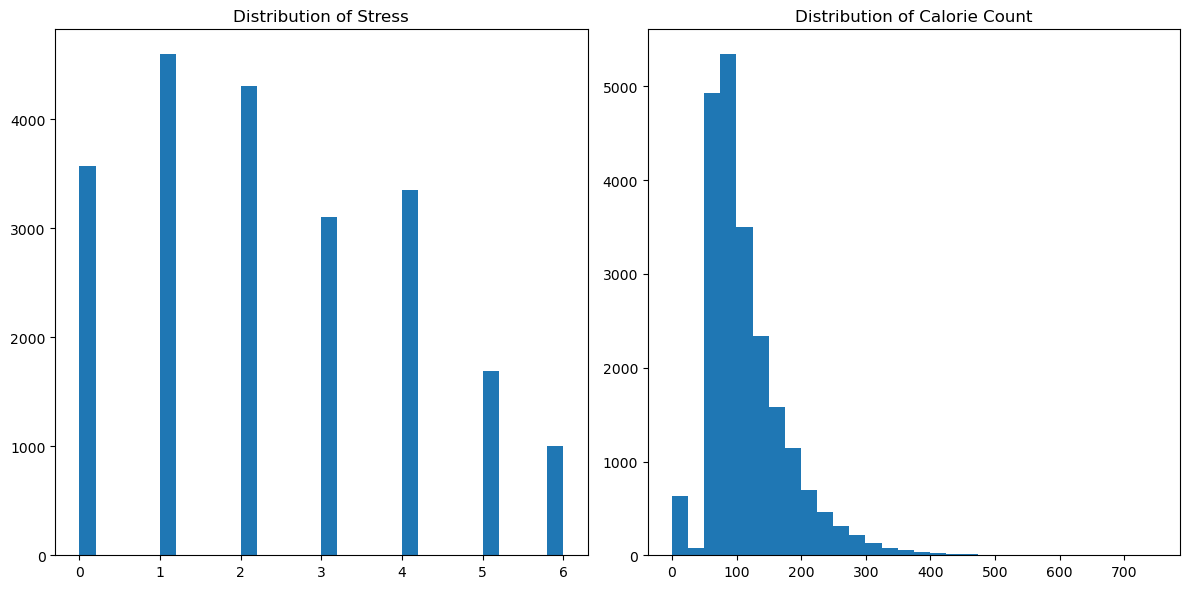

In [27]:
# Simple Matplotlib histograms for distribution plots
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['stress'], bins=30)
plt.title('Distribution of Stress')

plt.subplot(1, 2, 2)
plt.hist(df['calorie_count'], bins=30)
plt.title('Distribution of Calorie Count')

plt.tight_layout()
plt.show()

In [28]:
zero_count = (df['calorie_count'] == 0).sum()
print(zero_count)

631


Binarization

In [29]:
# Calculate personal means
personal_means = df.groupby('pcode').mean()[['stress', 'calorie_count']]

# Calculate overall means
overall_mean_stress = df['stress'].mean()
overall_mean_calories = df['calorie_count'].mean()

print("Personal Means:")
print(personal_means.head())

print("Overall Mean Stress:", overall_mean_stress)
print("Overall Mean Calorie:", overall_mean_calories)

Personal Means:
         stress  calorie_count
pcode                         
P001   0.653061     137.013274
P002   1.500000     126.914627
P003   3.536290     154.522211
P007   2.700508     115.951495
P008   4.004902     109.412317
Overall Mean Stress: 2.330990474428928
Overall Mean Calorie: 115.41428721693038


/tmp/ipykernel_37041/4274119673.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  personal_means = df.groupby('pcode').mean()[['stress', 'calorie_count']]


In [30]:
# Function to binarize based on personal means
def binarize_personal(row, personal_means):
    pcode = row['pcode']
    personal_mean_stress = personal_means.loc[pcode, 'stress']
    personal_mean_calories = personal_means.loc[pcode, 'calorie_count']
    
    row['stress_binary_personal'] = 1 if row['stress'] > personal_mean_stress else 0
    row['calorie_count_binary_personal'] = 1 if row['calorie_count'] > personal_mean_calories else 0
    return row

# Binarize based on personal means
df = df.apply(binarize_personal, axis=1, personal_means=personal_means)

# Binarize based on overall means
df['stress_binary_overall'] = df['stress'].apply(lambda x: 1 if x > overall_mean_stress else 0)
df['calorie_count_binary_overall'] = df['calorie_count'].apply(lambda x: 1 if x > overall_mean_calories else 0)

# Display the updated DataFrame
print(df.head())


  pcode                        timestamp  stress  calorie_count  \
0  P001 2021-11-24 11:39:29.541000+09:00       2     125.504053   
1  P001 2021-11-24 13:12:37.539000+09:00       0     191.793704   
2  P001 2021-11-24 14:29:48.862000+09:00       2     103.080952   
3  P001 2021-11-24 15:25:44.845000+09:00       1      99.597752   
4  P001 2021-11-24 16:24:39.285000+09:00       0      85.338402   

   stress_binary_personal  calorie_count_binary_personal  \
0                       1                              0   
1                       0                              1   
2                       1                              0   
3                       1                              0   
4                       0                              0   

   stress_binary_overall  calorie_count_binary_overall  
0                      0                             1  
1                      0                             1  
2                      0                             0  
3       

In [31]:
df

,pcode,timestamp,stress,calorie_count,stress_binary_personal,calorie_count_binary_personal,stress_binary_overall,calorie_count_binary_overall
0,P001,2021-11-24 11:39:29.541000+09:00,2,125.504053,1,0,0,1
1,P001,2021-11-24 13:12:37.539000+09:00,0,191.793704,0,1,0,1
2,P001,2021-11-24 14:29:48.862000+09:00,2,103.080952,1,0,0,0
3,P001,2021-11-24 15:25:44.845000+09:00,1,99.597752,1,0,0,0
4,P001,2021-11-24 16:24:39.285000+09:00,0,85.338402,0,0,0,0
...,...,...,...,...,...,...,...,...
21621,P135,2022-01-05 12:00:36.642000+09:00,5,59.070240,1,0,1,0
21622,P135,2022-01-05 13:22:37.520000+09:00,5,117.078761,1,1,1,1
21623,P135,2022-01-05 17:30:48.498000+09:00,4,61.772800,1,0,1,0
21624,P135,2022-01-05 18:45:41.705000+09:00,4,57.912000,1,0,1,0


In [32]:
df = df.drop_duplicates(subset=['pcode', 'timestamp'])

In [33]:
df

,pcode,timestamp,stress,calorie_count,stress_binary_personal,calorie_count_binary_personal,stress_binary_overall,calorie_count_binary_overall
0,P001,2021-11-24 11:39:29.541000+09:00,2,125.504053,1,0,0,1
1,P001,2021-11-24 13:12:37.539000+09:00,0,191.793704,0,1,0,1
2,P001,2021-11-24 14:29:48.862000+09:00,2,103.080952,1,0,0,0
3,P001,2021-11-24 15:25:44.845000+09:00,1,99.597752,1,0,0,0
4,P001,2021-11-24 16:24:39.285000+09:00,0,85.338402,0,0,0,0
...,...,...,...,...,...,...,...,...
21621,P135,2022-01-05 12:00:36.642000+09:00,5,59.070240,1,0,1,0
21622,P135,2022-01-05 13:22:37.520000+09:00,5,117.078761,1,1,1,1
21623,P135,2022-01-05 17:30:48.498000+09:00,4,61.772800,1,0,1,0
21624,P135,2022-01-05 18:45:41.705000+09:00,4,57.912000,1,0,1,0


In [34]:
esm_path = os.path.join('Intermediate', 'labels_1h_esmsyn_calorie.csv')
df.to_csv(esm_path, index=False)

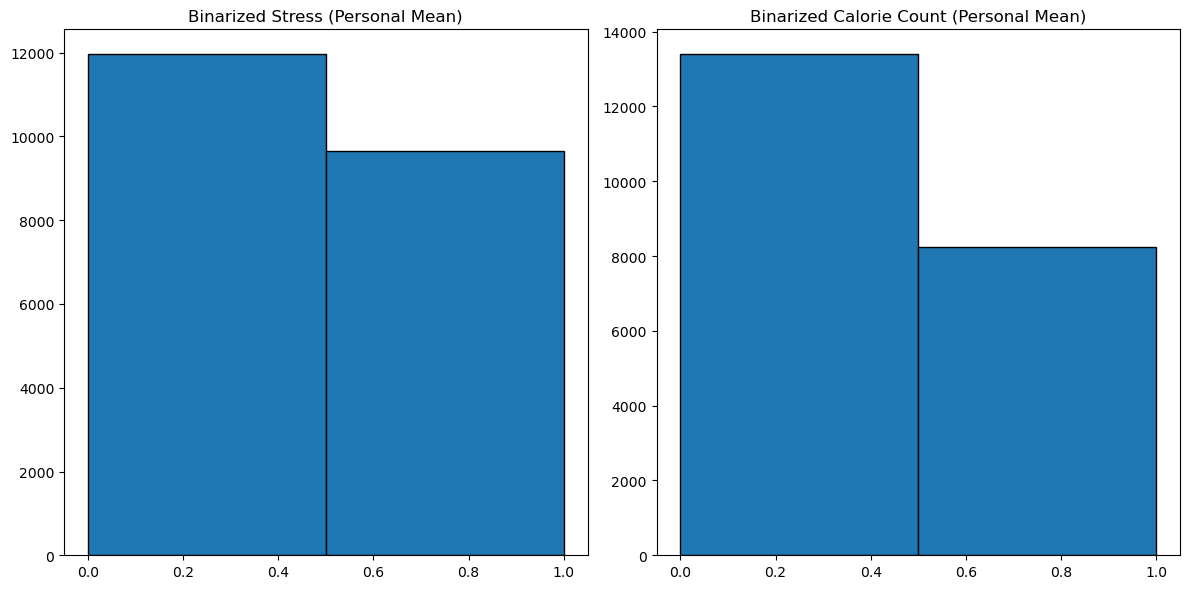

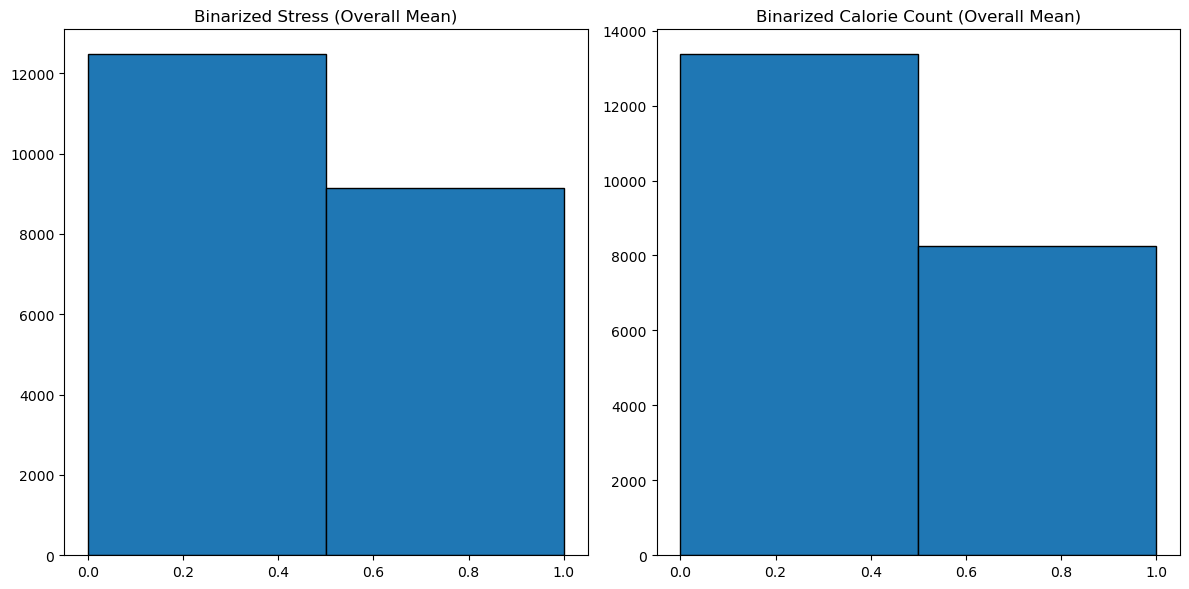

Correlation Matrix (Binarized Data):
                               stress_binary_personal  \
stress_binary_personal                       1.000000   
calorie_count_binary_personal               -0.060160   
stress_binary_overall                        0.728010   
calorie_count_binary_overall                -0.042646   

                               calorie_count_binary_personal  \
stress_binary_personal                             -0.060160   
calorie_count_binary_personal                       1.000000   
stress_binary_overall                              -0.054317   
calorie_count_binary_overall                        0.702724   

                               stress_binary_overall  \
stress_binary_personal                      0.728010   
calorie_count_binary_personal              -0.054317   
stress_binary_overall                       1.000000   
calorie_count_binary_overall               -0.047571   

                               calorie_count_binary_overall  
stress_binary

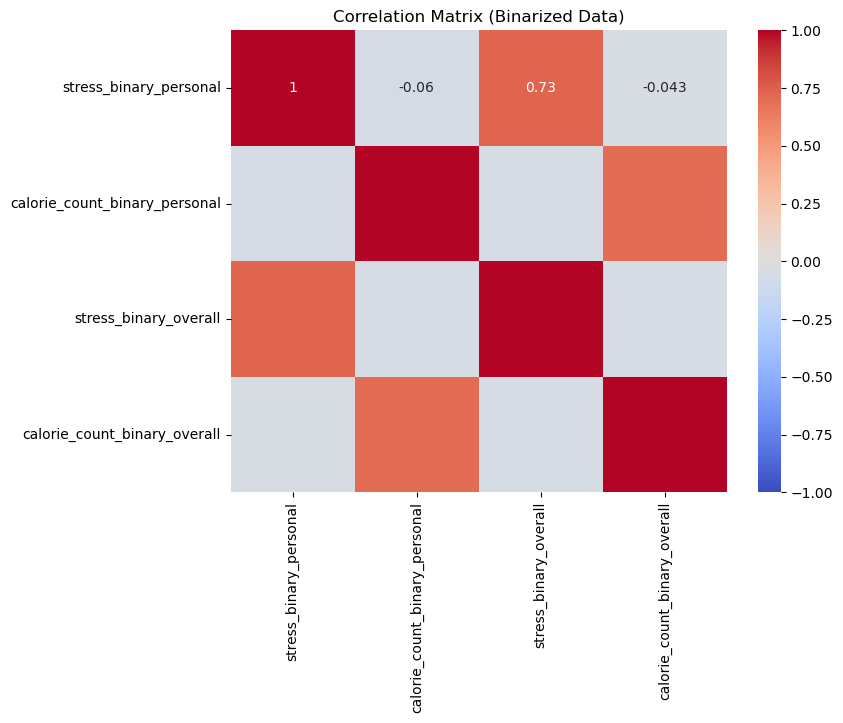

In [35]:
# EDA for Binarized Data

# Distribution plots for personal binarized data using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['stress_binary_personal'], bins=2, edgecolor='k')
plt.title('Binarized Stress (Personal Mean)')

plt.subplot(1, 2, 2)
plt.hist(df['calorie_count_binary_personal'], bins=2, edgecolor='k')
plt.title('Binarized Calorie Count (Personal Mean)')

plt.tight_layout()
plt.show()

# Distribution plots for overall binarized data using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['stress_binary_overall'], bins=2, edgecolor='k')
plt.title('Binarized Stress (Overall Mean)')

plt.subplot(1, 2, 2)
plt.hist(df['calorie_count_binary_overall'], bins=2, edgecolor='k')
plt.title('Binarized Calorie Count (Overall Mean)')

plt.tight_layout()
plt.show()

# Correlation analysis for binarized data
correlation_binarized = df[['stress_binary_personal', 'calorie_count_binary_personal',
                            'stress_binary_overall', 'calorie_count_binary_overall']].corr()
print("Correlation Matrix (Binarized Data):")
print(correlation_binarized)

# Heatmap for correlation matrix (binarized data) using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_binarized, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Binarized Data)')
plt.show()

In [36]:
zero_count = (df['calorie_count_binary_personal'] == 0).sum()
print(zero_count)

13390


In [37]:
zero_count = (df['calorie_count_binary_overall'] == 0).sum()
print(zero_count)

13366
